In [2]:
import os
import numpy as np
import argparse
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from load_data import load_masks, Dataset, DatasetMask, split_train_val_test
from inpaint_model import InPaintNet, Critic
from unet import UNet
from config import *
import torch.optim as optim
import wandb
from torchsummary import summary
from tiger.torch import SigmoidDiceLoss

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.


In [3]:
masks, scores = load_masks(verse2019_dir, cases=2)
train_set, val_set, _ = split_train_val_test(masks, scores, patch_size)
train_loader = DataLoader(train_set, batch_size=1, shuffle=False)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)

Loading masks from /mnt/netcache/bodyct/experiments/vertebra_fracture_detection_t9560/datasets/verse2019/masks_bodies...


  0%|          | 0/2 [00:00<?, ?it/s]

Available cases: 2 
train: 1, val: 0, test: 1
Extracting patches...


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train: 4, val: 0, test: 1


In [10]:
# declare device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
unet = UNet().to(device)
summary(unet.to(device), input_size=(1, *patch_size), batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [1, 32, 186, 186, 186]             896
         LeakyReLU-2     [1, 32, 186, 186, 186]               0
            Conv3d-3     [1, 32, 184, 184, 184]          27,680
         LeakyReLU-4     [1, 32, 184, 184, 184]               0
        DoubleConv-5     [1, 32, 184, 184, 184]               0
         MaxPool3d-6        [1, 32, 92, 92, 92]               0
         DownBlock-7        [1, 32, 92, 92, 92]               0
            Conv3d-8        [1, 64, 90, 90, 90]          55,360
         LeakyReLU-9        [1, 64, 90, 90, 90]               0
           Conv3d-10        [1, 64, 88, 88, 88]         110,656
        LeakyReLU-11        [1, 64, 88, 88, 88]               0
       DoubleConv-12        [1, 64, 88, 88, 88]               0
        MaxPool3d-13        [1, 64, 44, 44, 44]               0
        DownBlock-14        [1, 64, 44,


Loss: 0.7525309324264526


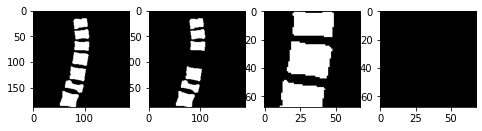


Loss: 0.7501899003982544


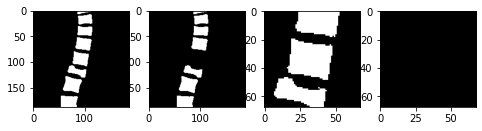


Loss: 0.7492955327033997


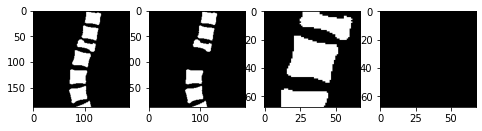


Loss: 0.7485750913619995


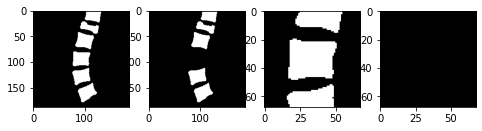


Loss: 0.7523787021636963


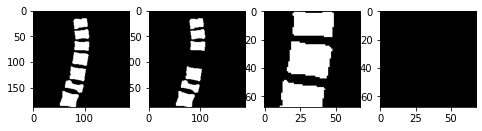


Loss: 0.7500432133674622


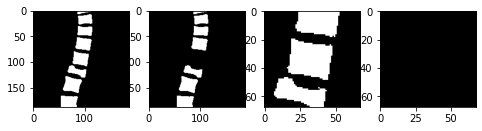


Loss: 0.7491509318351746


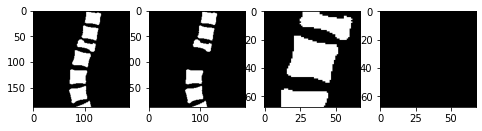


Loss: 0.7484319806098938


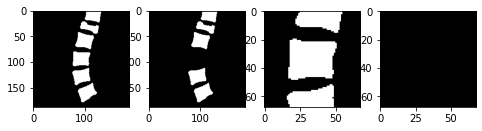


Loss: 0.7522262334823608


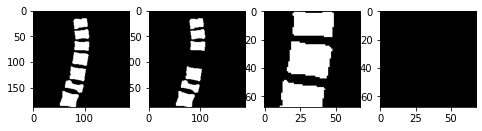


Loss: 0.7498961687088013


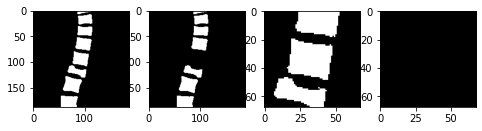


Loss: 0.7490058541297913


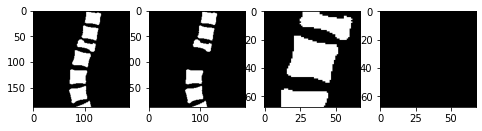


Loss: 0.7482883930206299


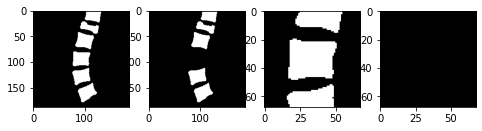


Loss: 0.7520731687545776


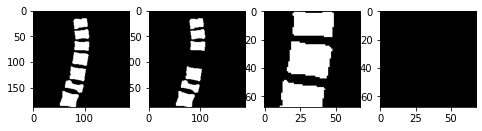


Loss: 0.7497485876083374


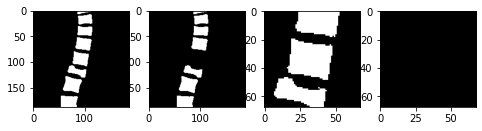


Loss: 0.7488600611686707


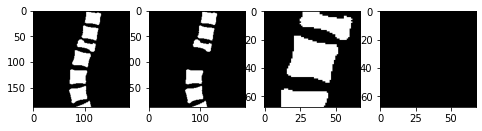


Loss: 0.7481440901756287


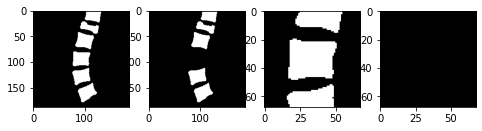


Loss: 0.7519192099571228


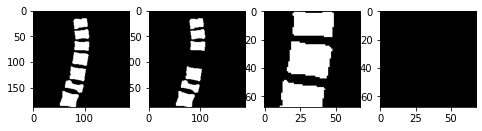


Loss: 0.7496000528335571


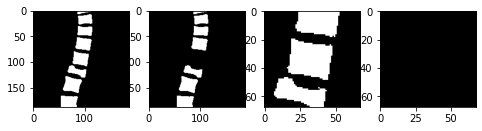


Loss: 0.748713493347168


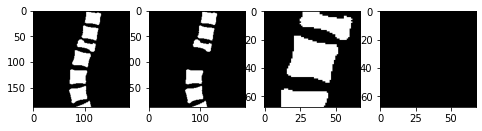


Loss: 0.7479989528656006


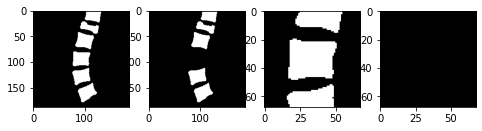


Loss: 0.7517645955085754


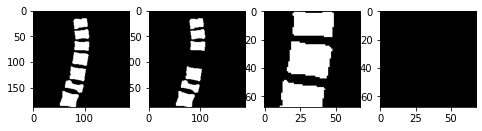


Loss: 0.7494508028030396


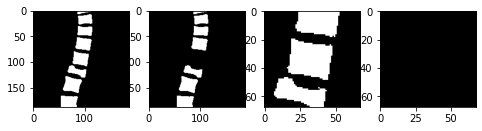


Loss: 0.7485660910606384


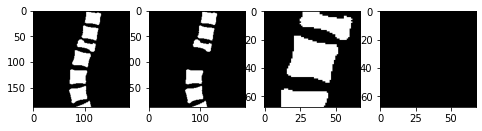


Loss: 0.7478529810905457


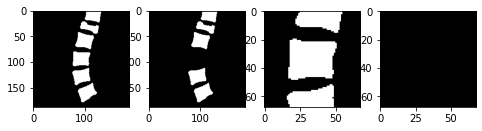


Loss: 0.7516087889671326


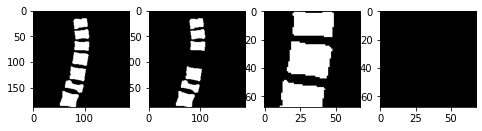


Loss: 0.7493004202842712


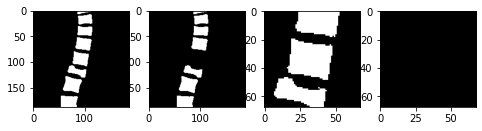


Loss: 0.7484175562858582


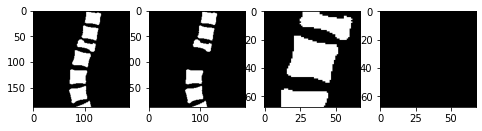


Loss: 0.74770587682724


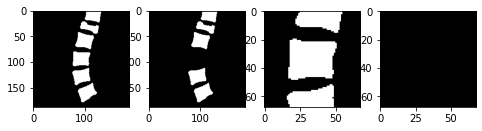


Loss: 0.7514517307281494


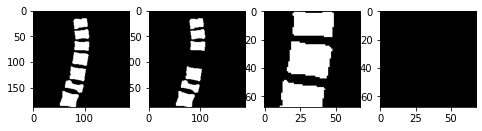


Loss: 0.7491487860679626


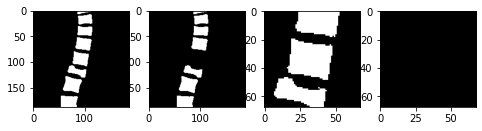


Loss: 0.748267650604248


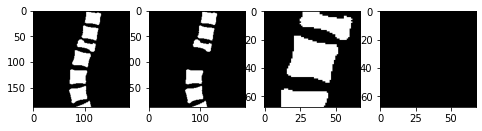


Loss: 0.7475572824478149


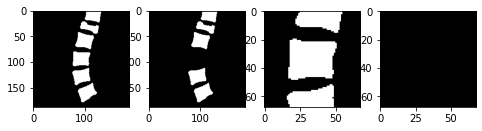


Loss: 0.7512930631637573


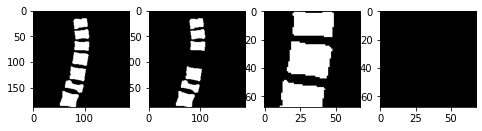


Loss: 0.7489954233169556


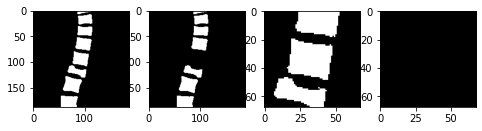


Loss: 0.7481158971786499


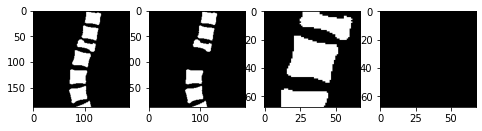


Loss: 0.7474067807197571


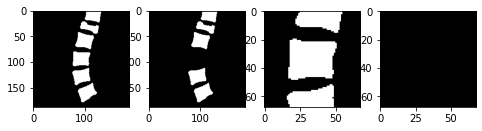


Loss: 0.7511321306228638


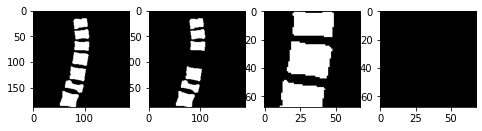


Loss: 0.7488396167755127


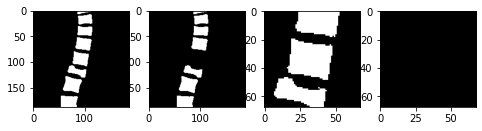


Loss: 0.7479615211486816


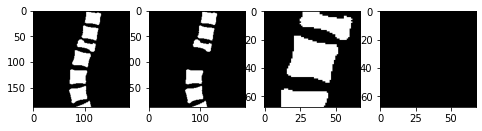


Loss: 0.7472532987594604


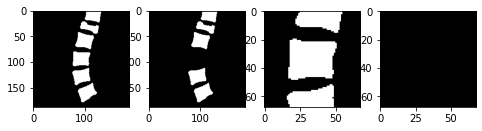


Loss: 0.7509675025939941


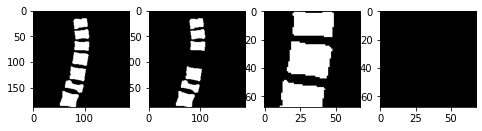


Loss: 0.7486799359321594


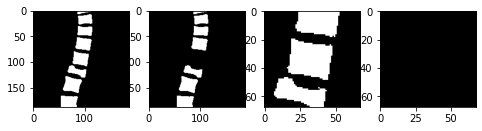


Loss: 0.7478029131889343


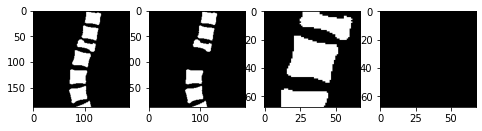


Loss: 0.7470949292182922


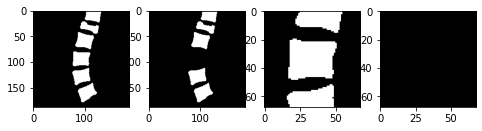


Loss: 0.7507971525192261


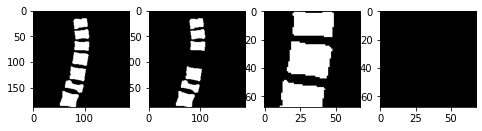


Loss: 0.7485138177871704


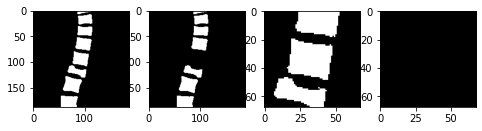


Loss: 0.7476369142532349


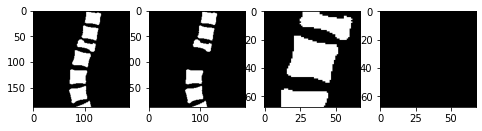


Loss: 0.7469285130500793


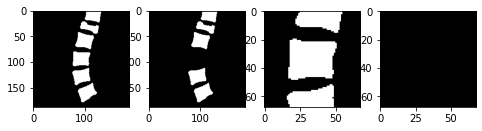


Loss: 0.7506167888641357


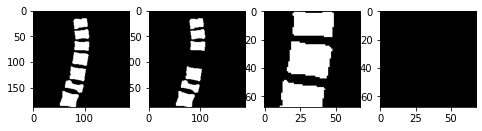


Loss: 0.7483367323875427


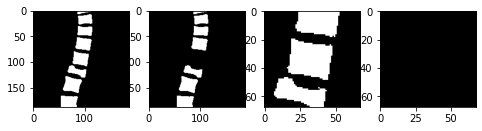


Loss: 0.7474585175514221


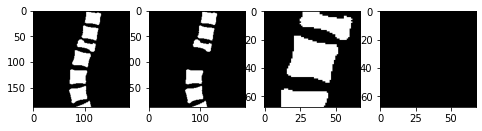


Loss: 0.7467477321624756


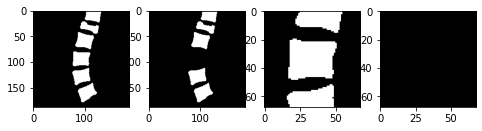


Loss: 0.750419020652771


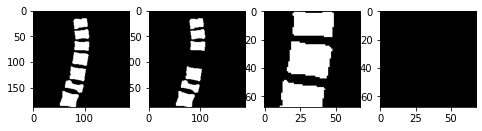


Loss: 0.7481402158737183


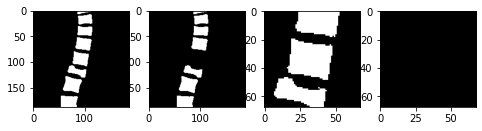


Loss: 0.7472579479217529


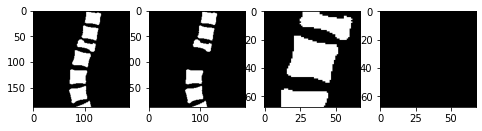


Loss: 0.7465416789054871


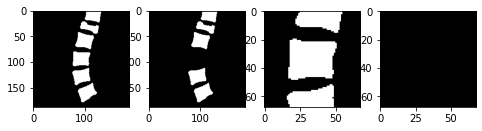


Loss: 0.7501896619796753


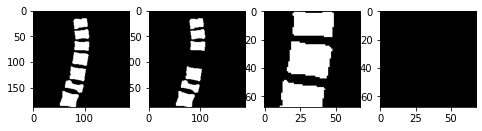


Loss: 0.7479081153869629


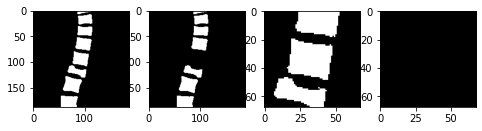


Loss: 0.747014582157135


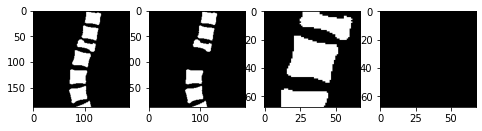


Loss: 0.746263325214386


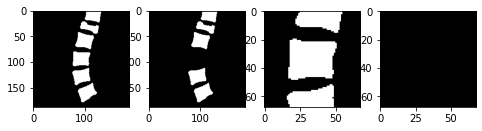


Loss: 0.749828577041626


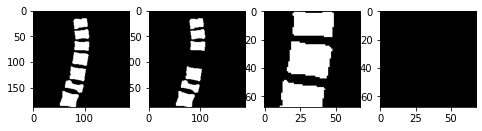


Loss: 0.747455358505249


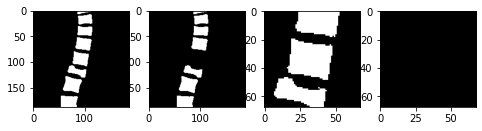


Loss: 0.7464211583137512


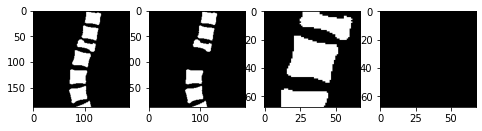


Loss: 0.745498776435852


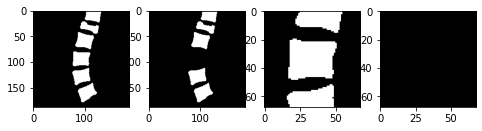


Loss: 0.7487357258796692


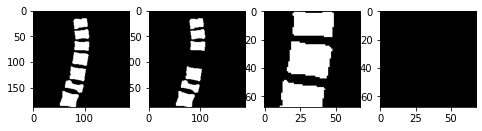


Loss: 0.7460916638374329


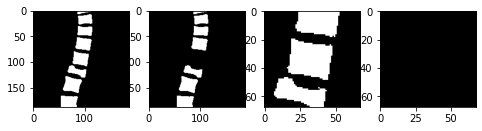


Loss: 0.7446765899658203


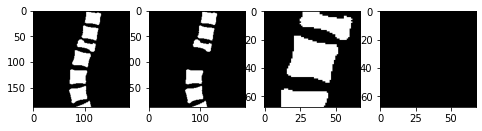


Loss: 0.74322509765625


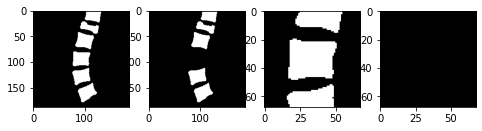


Loss: 0.7455188632011414


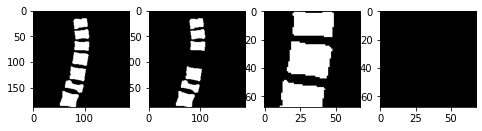


Loss: 0.7418301701545715


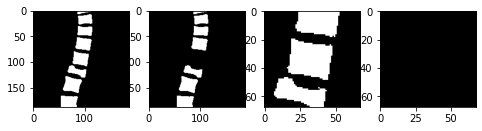


Loss: 0.7386628985404968


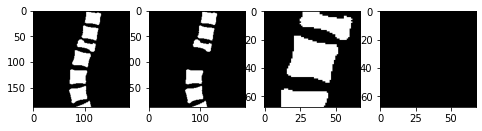


Loss: 0.7342701554298401


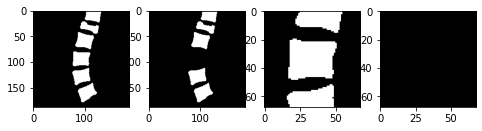


Loss: 0.7299517393112183


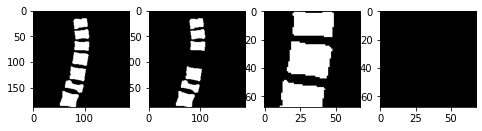


Loss: 0.7143663763999939


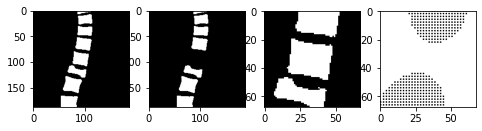


Loss: 0.6805276870727539


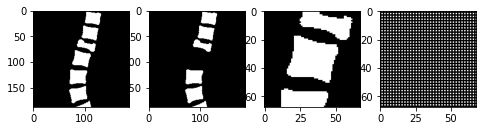


Loss: 0.6053914427757263


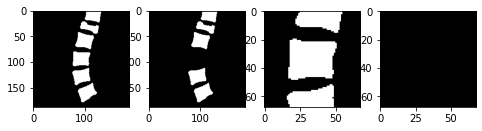


Loss: 0.6128132939338684


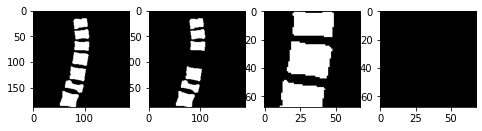


Loss: 0.558347761631012


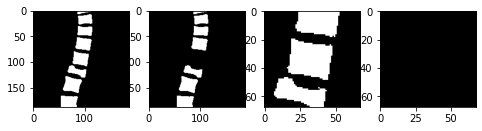


Loss: 0.5647117495536804


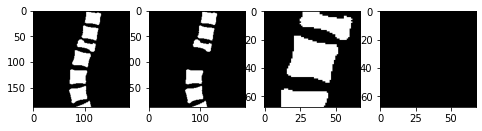


Loss: 0.5784192681312561


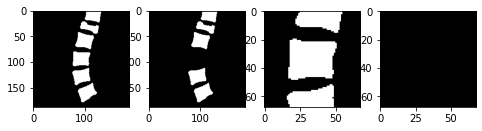


Loss: 0.5539230108261108


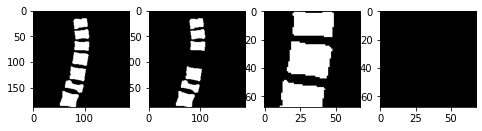


Loss: 0.526922881603241


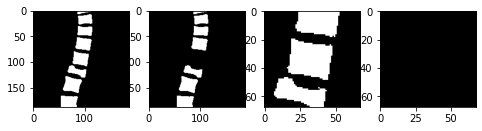


Loss: 0.5200443267822266


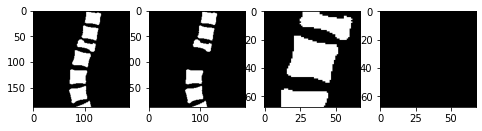


Loss: 0.551386833190918


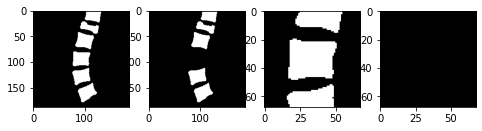


Loss: 0.4771699011325836


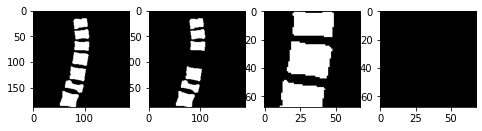


Loss: 0.4982147514820099


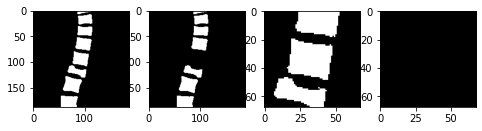


Loss: 0.509454071521759


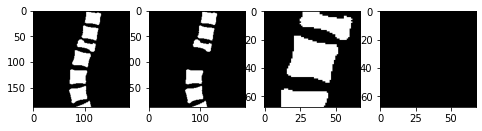


Loss: 0.5076461434364319


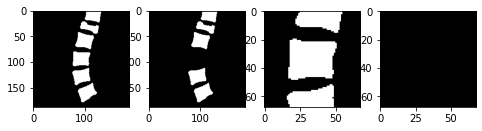


Loss: 0.4683997333049774


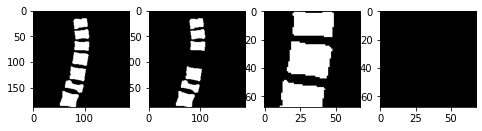


Loss: 0.4861944019794464


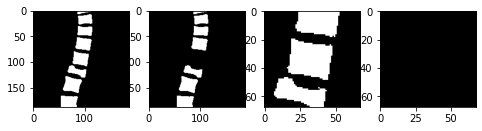


Loss: 0.5023303031921387


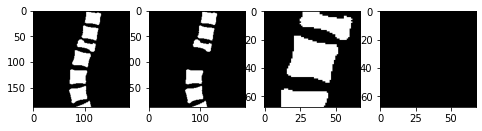


Loss: 0.4873032867908478


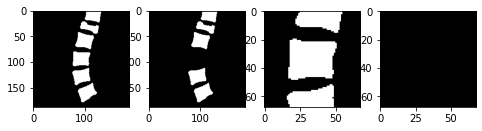


Loss: 0.457081139087677


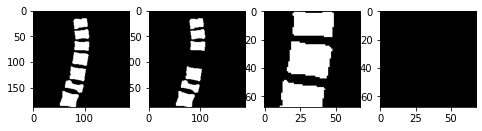


Loss: 0.46763232350349426


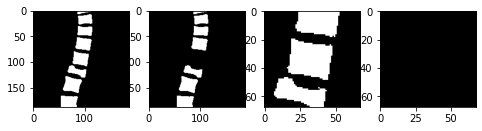


Loss: 0.4458271265029907


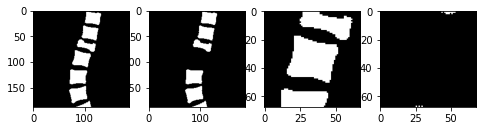


Loss: 0.40888723731040955


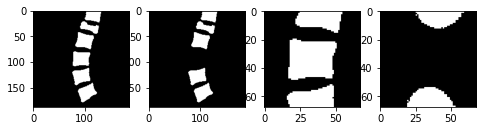


Loss: 0.31599393486976624


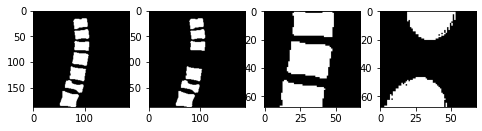


Loss: 0.34396660327911377


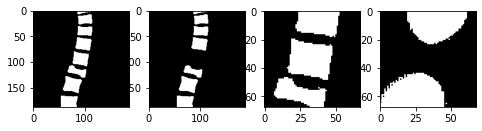


Loss: 0.4348085820674896


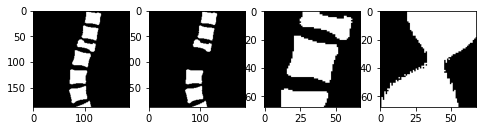


Loss: 0.5147884488105774


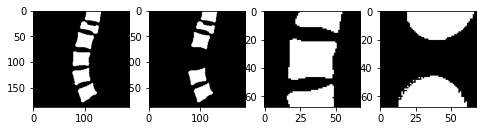


Loss: 0.3828641474246979


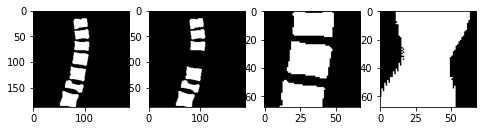


Loss: 0.32273733615875244


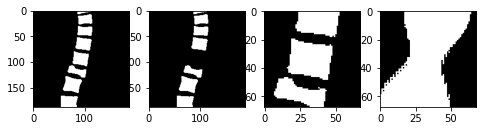


Loss: 0.43657657504081726


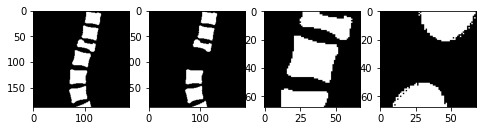


Loss: 0.38832157850265503


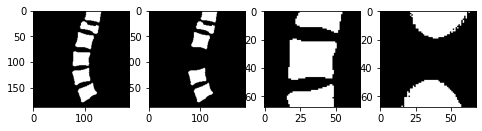


Loss: 0.33001452684402466


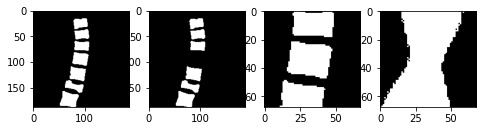


Loss: 0.37309664487838745


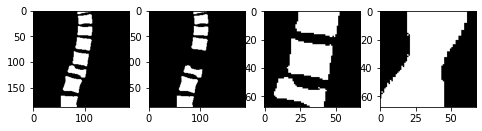


Loss: 0.3428537845611572


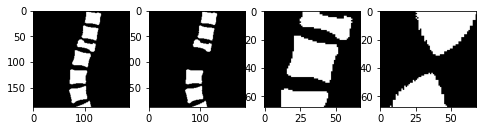


Loss: 0.3502334654331207


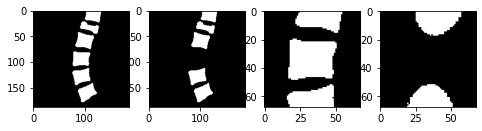


Loss: 0.27476364374160767


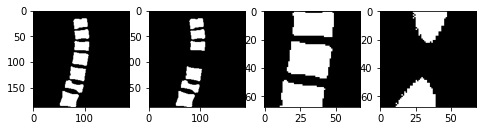


Loss: 0.3125612139701843


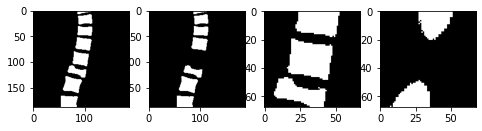


Loss: 0.3363026976585388


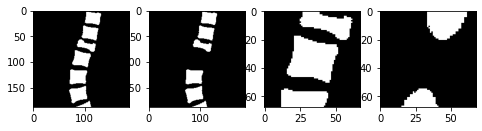


Loss: 0.31734564900398254


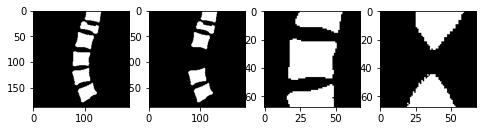


Loss: 0.30335578322410583


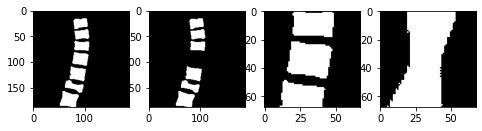


Loss: 0.3155639171600342


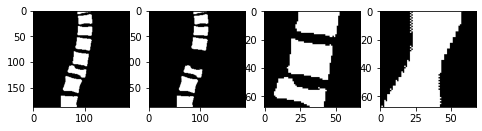


Loss: 0.287666916847229


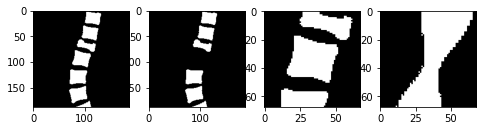


Loss: 0.2989956736564636


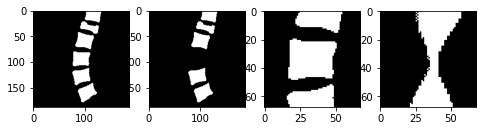


Loss: 0.23029376566410065


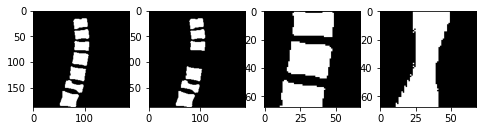


Loss: 0.2559930980205536


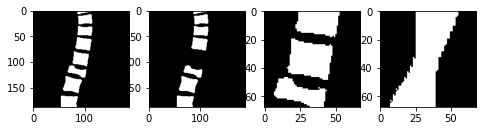


Loss: 0.2666894197463989


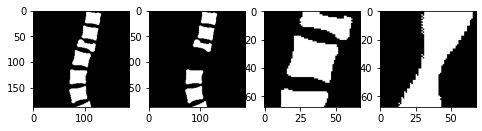


Loss: 0.2644772529602051


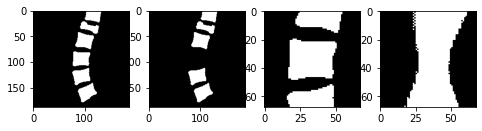


Loss: 0.2405264526605606


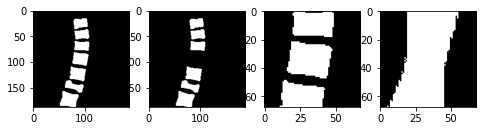


Loss: 0.25096413493156433


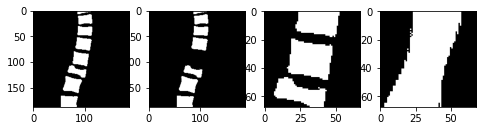


Loss: 0.24727700650691986


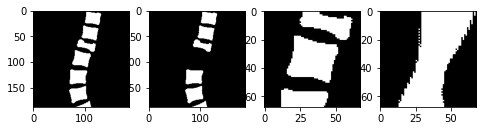


Loss: 0.2659446895122528


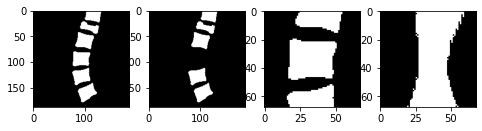


Loss: 0.20419596135616302


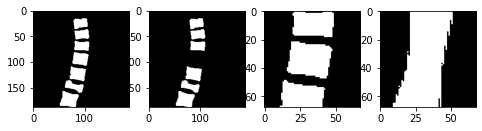


Loss: 0.2308349609375


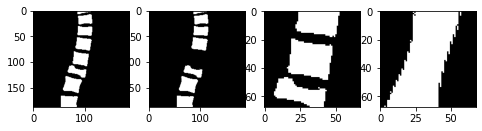


Loss: 0.23294927179813385


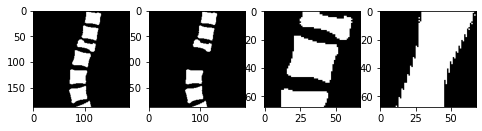


Loss: 0.23696713149547577


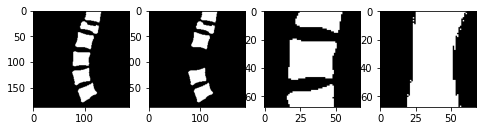


Loss: 0.20063240826129913


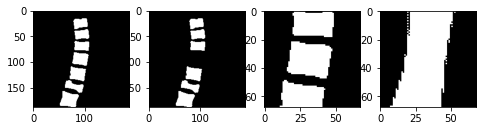


Loss: 0.22409871220588684


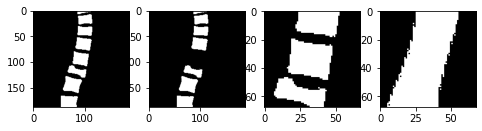


Loss: 0.22958841919898987


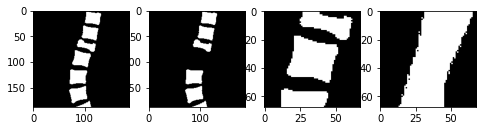


Loss: 0.23127496242523193


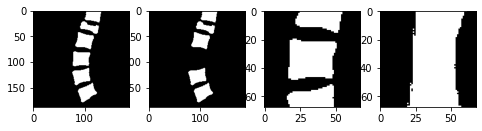


Loss: 0.19610317051410675


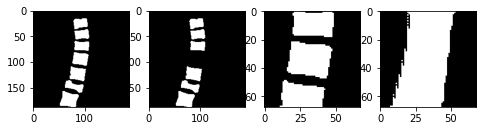


Loss: 0.2208731770515442


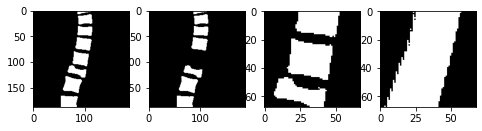


Loss: 0.21974629163742065


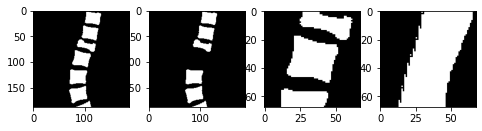


Loss: 0.22478722035884857


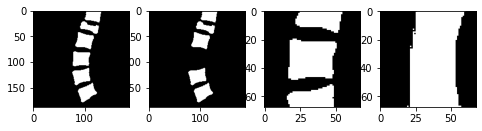


Loss: 0.19056516885757446


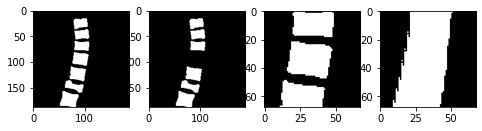


Loss: 0.2178197056055069


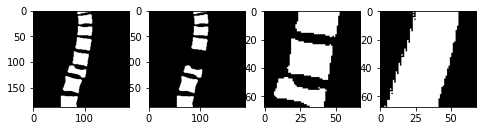


Loss: 0.21854624152183533


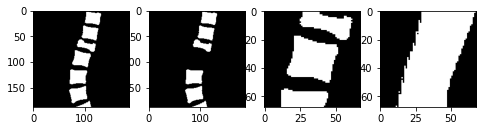


Loss: 0.22073328495025635


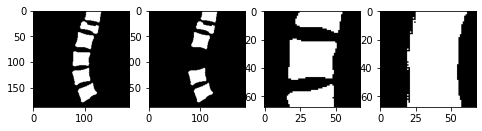


Loss: 0.18122728168964386


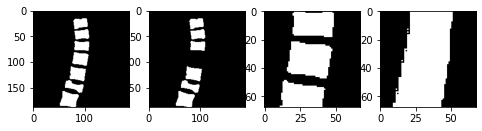


Loss: 0.21429477632045746


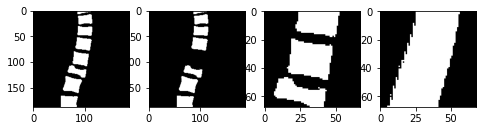


Loss: 0.22394396364688873


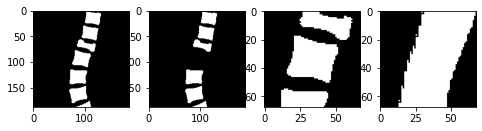


Loss: 0.23327231407165527


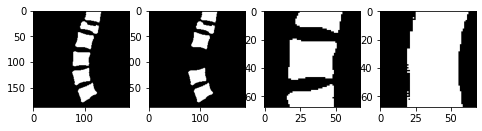


Loss: 0.17699787020683289


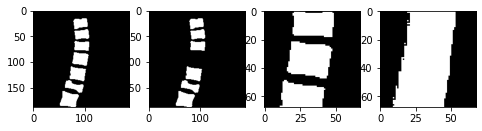


Loss: 0.20960836112499237


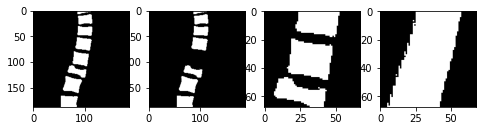


Loss: 0.22879546880722046


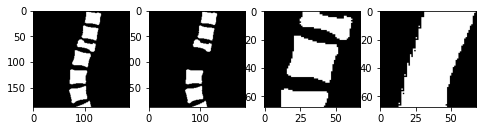


Loss: 0.2211150825023651


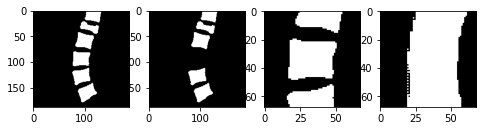


Loss: 0.18484680354595184


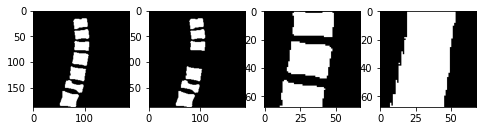


Loss: 0.215867280960083


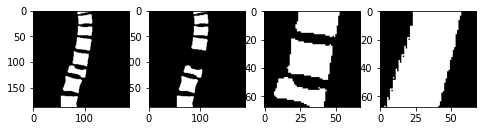


Loss: 0.21211184561252594


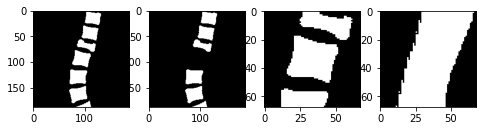


Loss: 0.20936939120292664


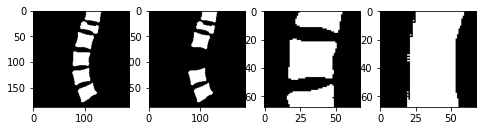


Loss: 0.18766319751739502


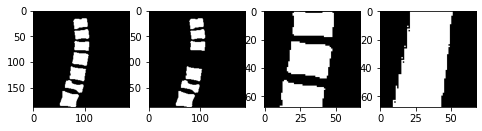


Loss: 0.21497362852096558


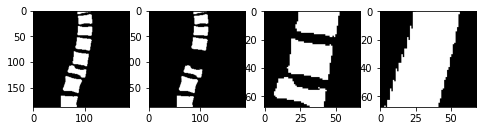


Loss: 0.21747364103794098


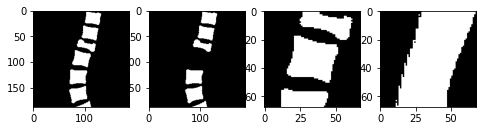


Loss: 0.21308577060699463


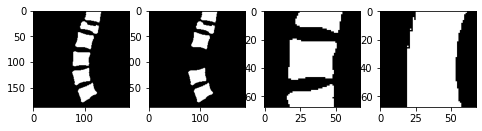


Loss: 0.17721772193908691


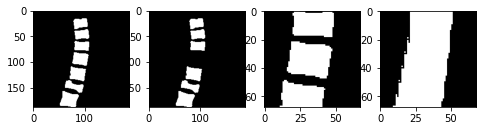


Loss: 0.21022696793079376


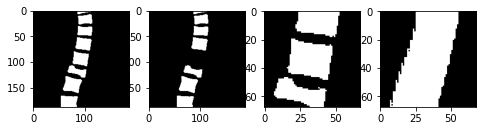


Loss: 0.22142411768436432


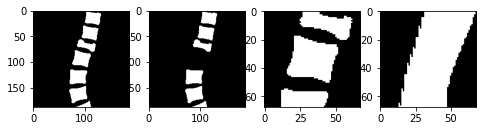


Loss: 0.2234506905078888


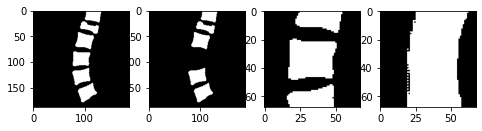


Loss: 0.18142297863960266


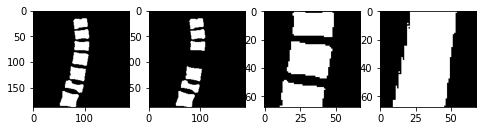


Loss: 0.2022770494222641


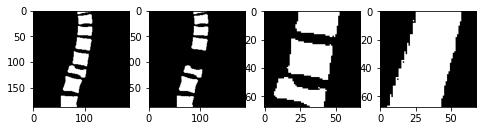


Loss: 0.22470630705356598


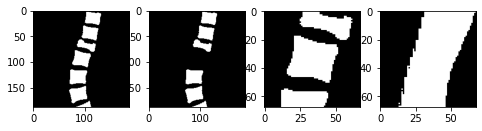


Loss: 0.21786929666996002


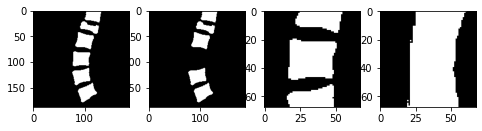


Loss: 0.17786966264247894


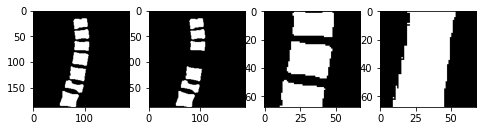


Loss: 0.21356120705604553


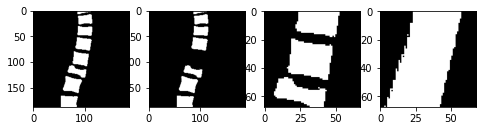


Loss: 0.21275663375854492


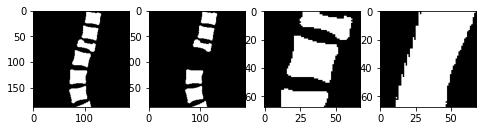


Loss: 0.20104320347309113


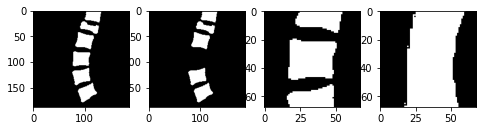


Loss: 0.1923745721578598


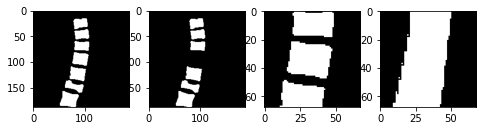


Loss: 0.215480238199234


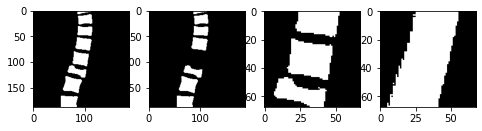


Loss: 0.21491320431232452


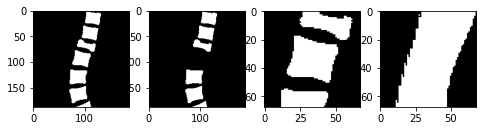


Loss: 0.21441633999347687


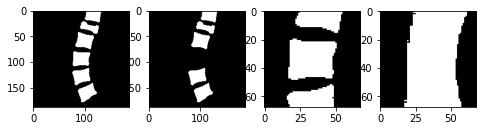


Loss: 0.16954249143600464


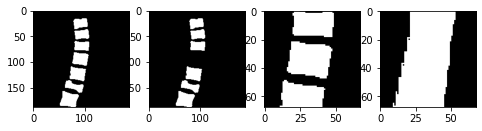


Loss: 0.20269078016281128


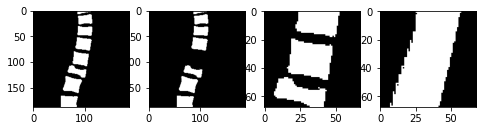


Loss: 0.23351801931858063


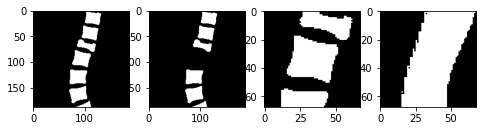


Loss: 0.21851634979248047


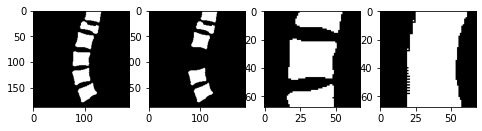


Loss: 0.18152327835559845


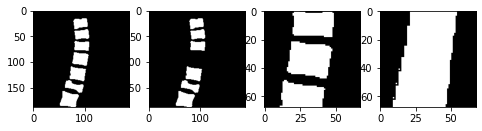


Loss: 0.20542103052139282


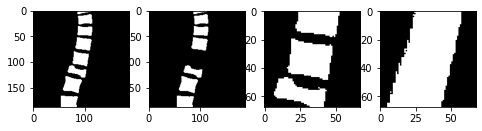


Loss: 0.2154320627450943


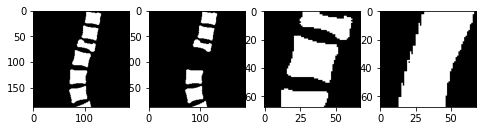


Loss: 0.21327534317970276


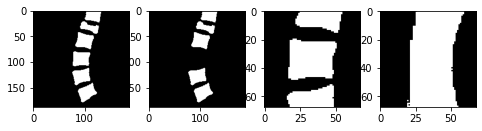


Loss: 0.17812250554561615


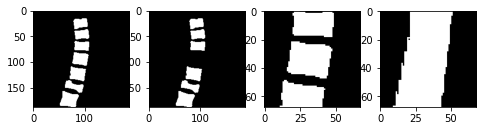


Loss: 0.20988120138645172


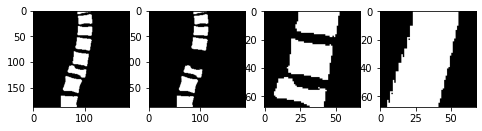


Loss: 0.21823075413703918


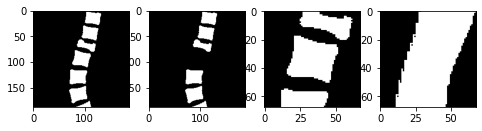


Loss: 0.20303860306739807


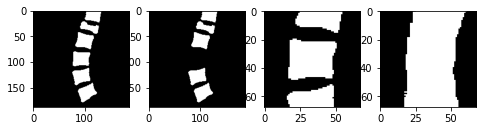


Loss: 0.18044017255306244


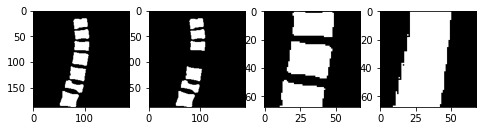


Loss: 0.2165047824382782


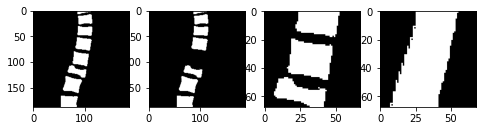


Loss: 0.2127048522233963


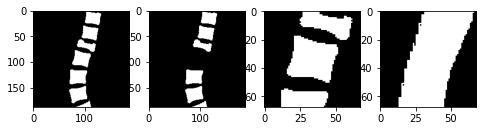


Loss: 0.20943394303321838


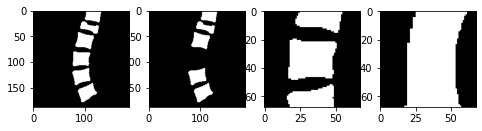


Loss: 0.173648864030838


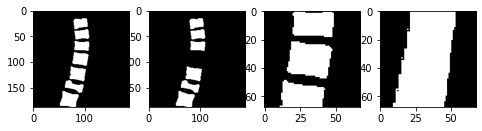


Loss: 0.19730374217033386


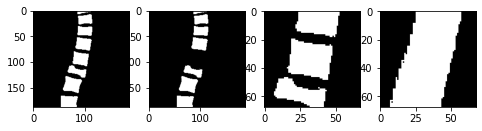


Loss: 0.22316287457942963


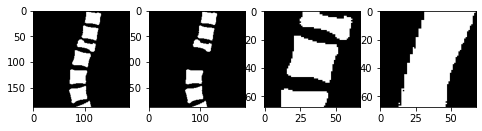


Loss: 0.21468839049339294


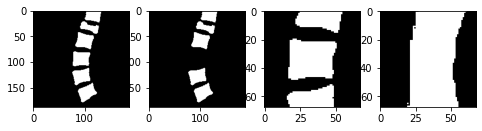


Loss: 0.16561952233314514


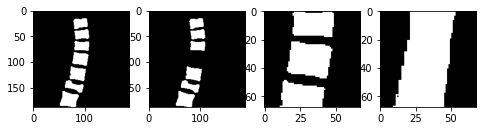


Loss: 0.20053929090499878


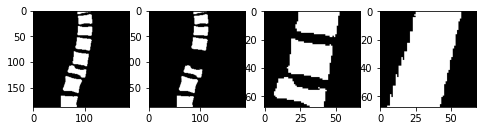


Loss: 0.21301384270191193


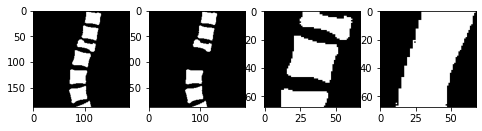


Loss: 0.19913311302661896


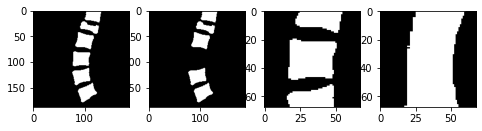


Loss: 0.17468279600143433


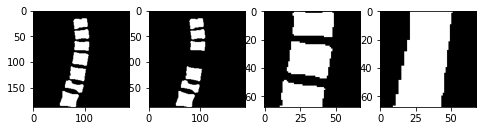


Loss: 0.20720894634723663


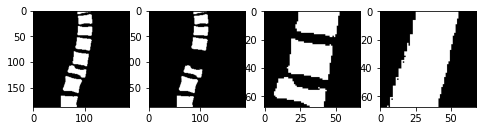


Loss: 0.21015653014183044


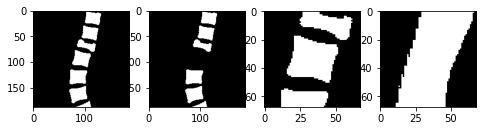


Loss: 0.2002885937690735


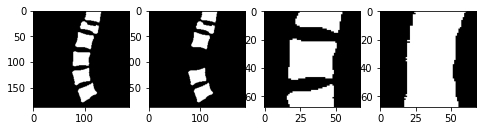


Loss: 0.1690158247947693


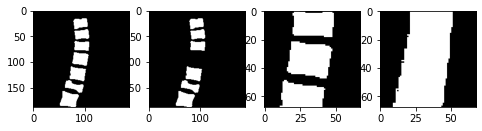


Loss: 0.1996246874332428


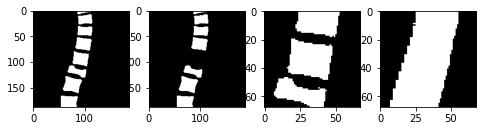


Loss: 0.21560081839561462


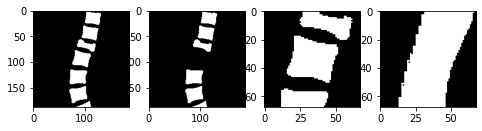


Loss: 0.2031351625919342


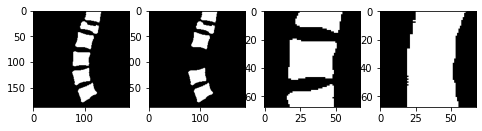


Loss: 0.1654438078403473


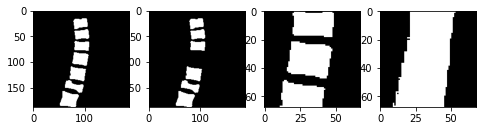


Loss: 0.1963939666748047


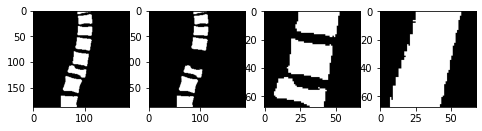


Loss: 0.21402083337306976


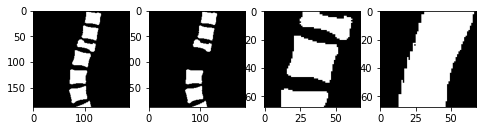


Loss: 0.2017010748386383


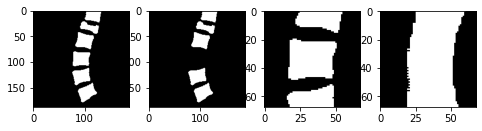


Loss: 0.1650506556034088


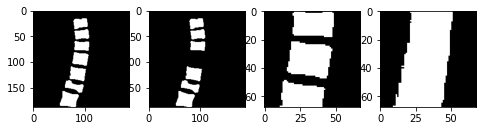


Loss: 0.19830670952796936


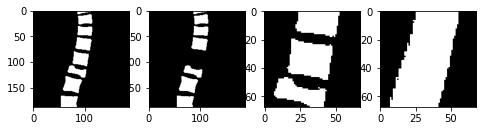


Loss: 0.210927814245224


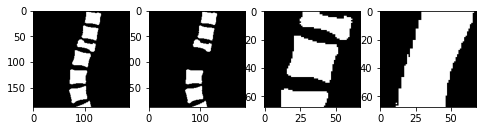


Loss: 0.19629748165607452


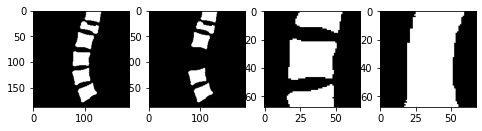


Loss: 0.16670258343219757


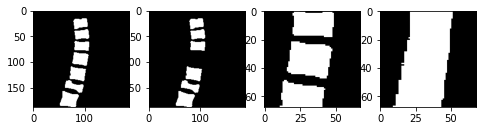


Loss: 0.20017439126968384


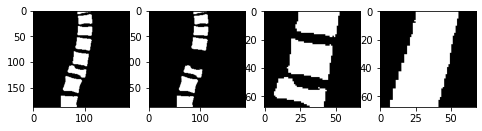


Loss: 0.2102397084236145


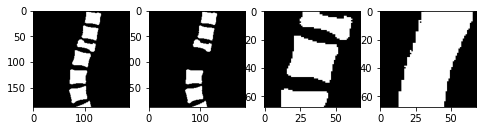


Loss: 0.19678740203380585


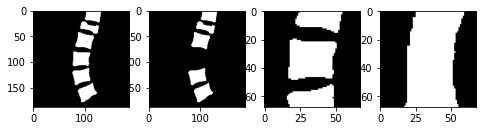


Loss: 0.16398164629936218


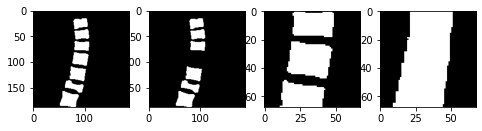


Loss: 0.19524723291397095


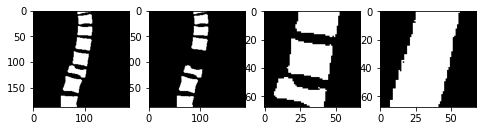


Loss: 0.21234896779060364


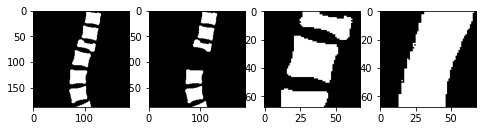


Loss: 0.1975693702697754


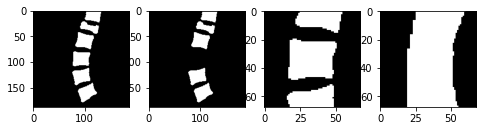


Loss: 0.1620642989873886


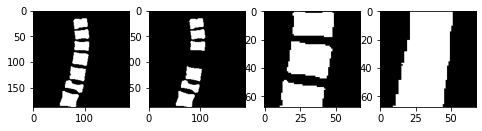


Loss: 0.19477325677871704


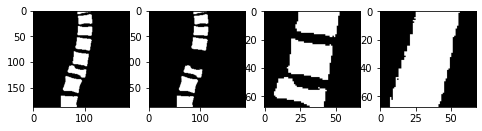


Loss: 0.2102118879556656


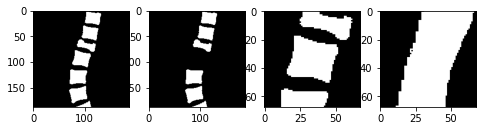


Loss: 0.1940278261899948


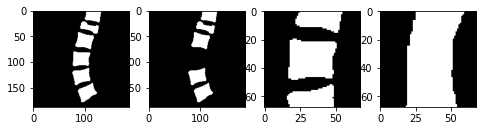


Loss: 0.1626644879579544


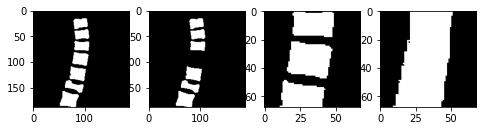


Loss: 0.19571369886398315


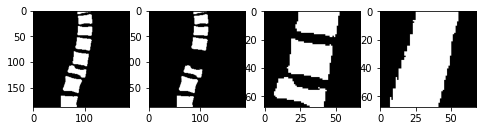


Loss: 0.20869924128055573


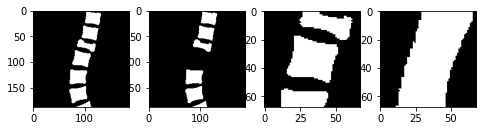


Loss: 0.19176171720027924


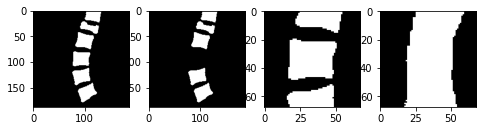


Loss: 0.16139739751815796


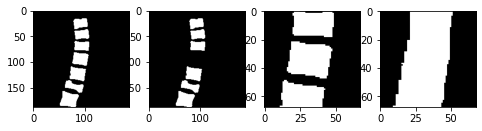


Loss: 0.19412367045879364


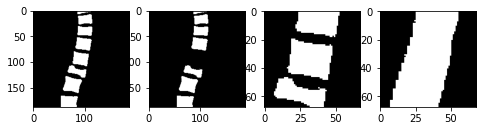


Loss: 0.20908142626285553


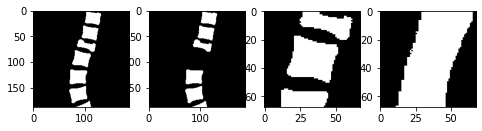


Loss: 0.19152036309242249


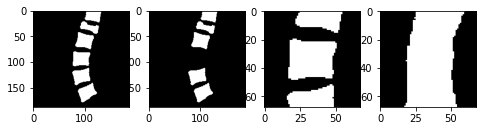


Loss: 0.159624382853508


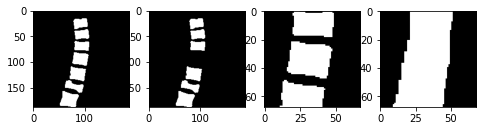


Loss: 0.19185906648635864


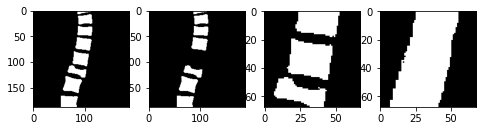


Loss: 0.2085271030664444


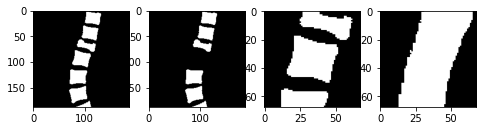


Loss: 0.18958497047424316


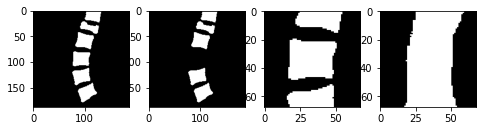


Loss: 0.159153014421463


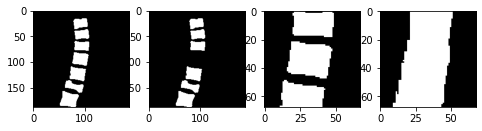


Loss: 0.19163371622562408


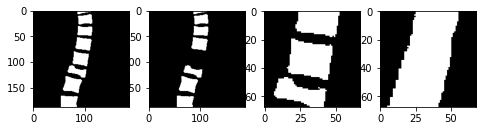


Loss: 0.20576409995555878


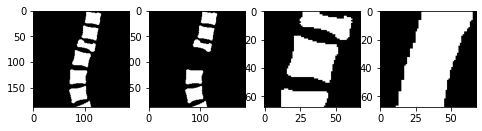


Loss: 0.18647310137748718


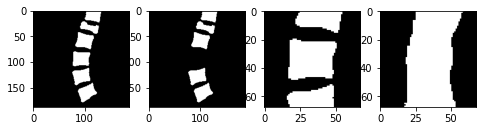


Loss: 0.1579563319683075


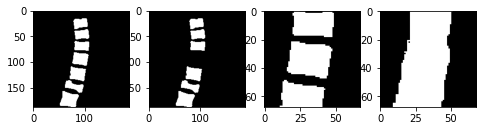


Loss: 0.19002915918827057


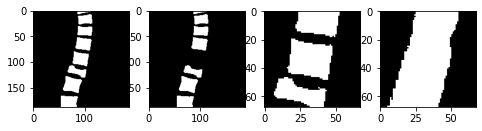


Loss: 0.20487678050994873


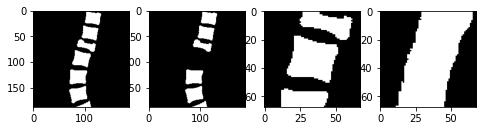


Loss: 0.18404757976531982


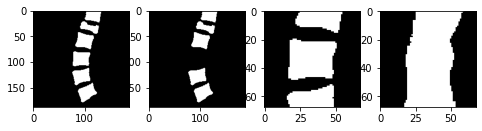


Loss: 0.15483525395393372


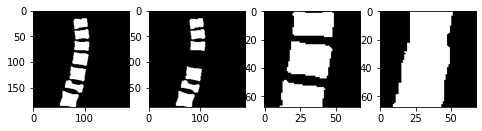


Loss: 0.18681257963180542


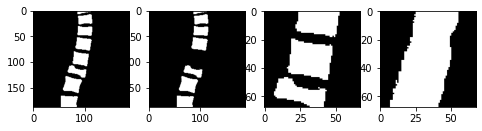


Loss: 0.20441699028015137


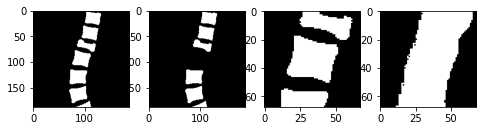


Loss: 0.18104493618011475


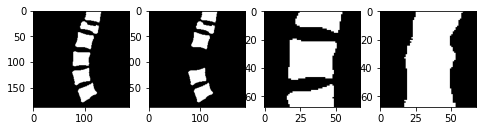


Loss: 0.15350161492824554


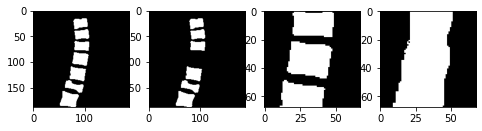


Loss: 0.18440277874469757


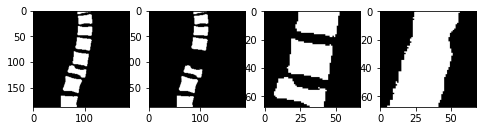


Loss: 0.20251049101352692


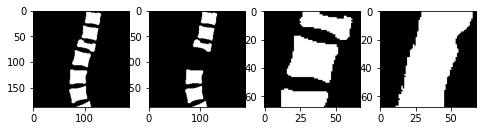


Loss: 0.1771656721830368


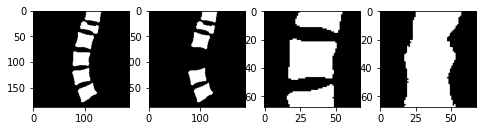


Loss: 0.1542215347290039


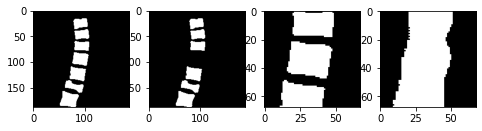


Loss: 0.18127743899822235


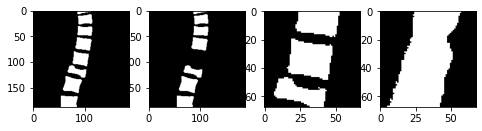


Loss: 0.20387238264083862


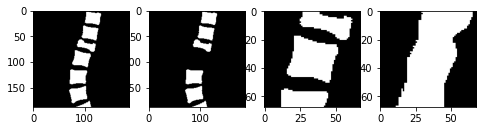


Loss: 0.17405271530151367


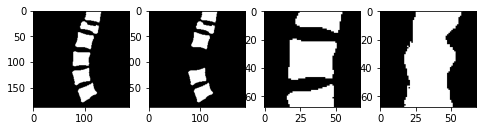


Loss: 0.15643210709095


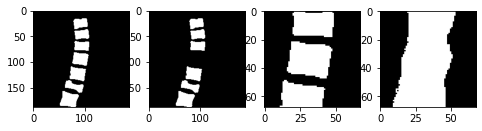


Loss: 0.1782410442829132


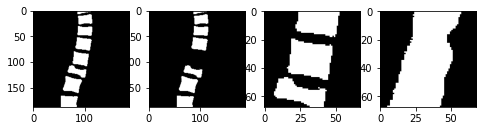


Loss: 0.20629578828811646


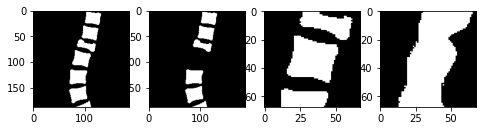


Loss: 0.17092140018939972


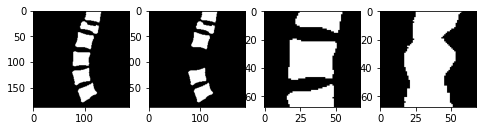


Loss: 0.15867964923381805


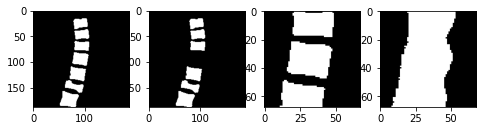


Loss: 0.17734448611736298


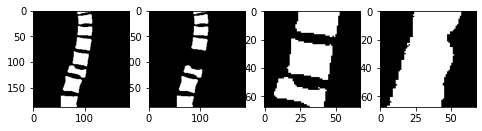


Loss: 0.20410676300525665


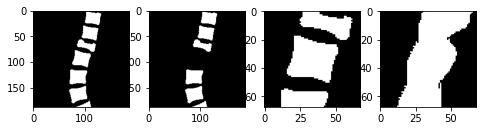


Loss: 0.1709693819284439


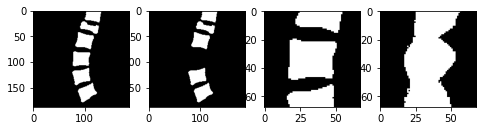


Loss: 0.1514311134815216


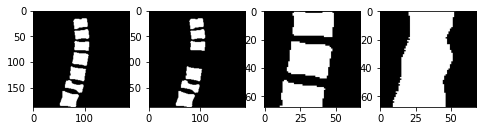


Loss: 0.18050707876682281


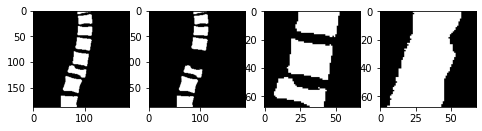


Loss: 0.1960962861776352


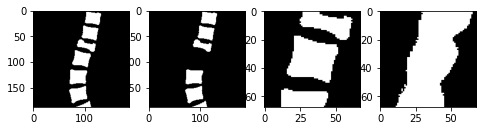


Loss: 0.17670975625514984


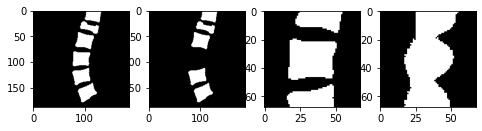


Loss: 0.1416618973016739


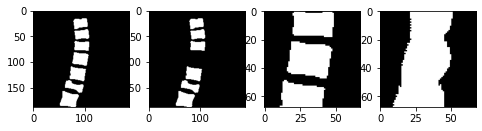


Loss: 0.1847950667142868


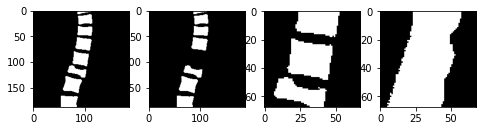


Loss: 0.19126629829406738


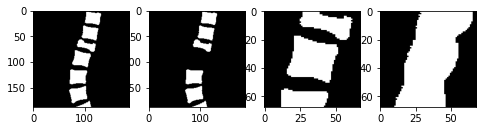


Loss: 0.17222224175930023


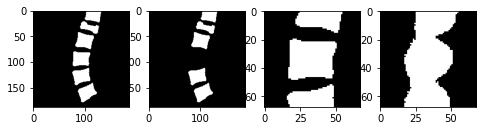


Loss: 0.14860643446445465


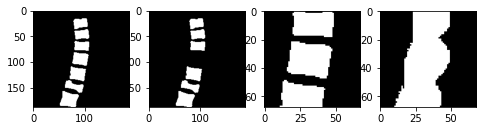


Loss: 0.17222678661346436


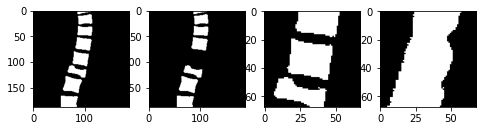


Loss: 0.20805086195468903


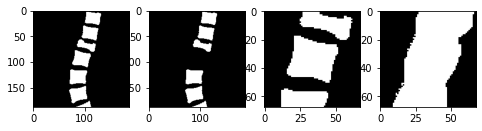


Loss: 0.15952932834625244


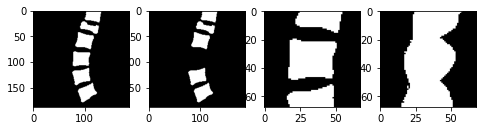


Loss: 0.1543361395597458


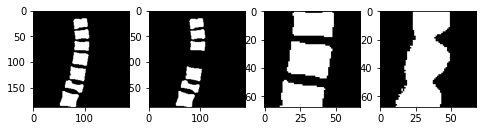


Loss: 0.17670811712741852


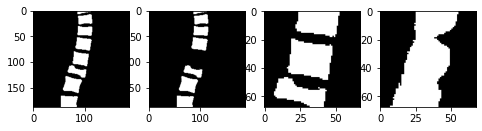


Loss: 0.19212079048156738


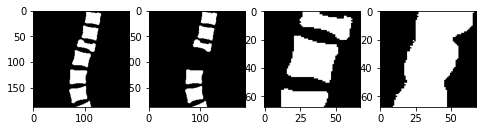


Loss: 0.17310379445552826


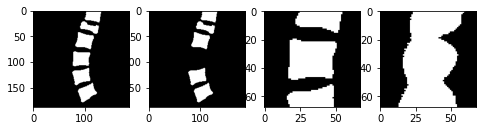


Loss: 0.13364170491695404


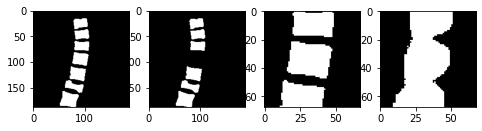


Loss: 0.1839563101530075


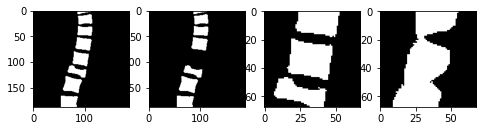


Loss: 0.18428747355937958


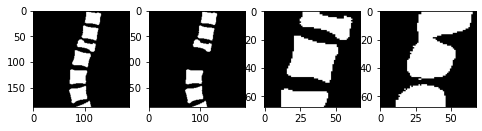


Loss: 0.1672549545764923


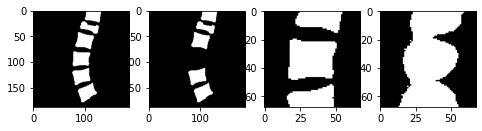


Loss: 0.14175720512866974


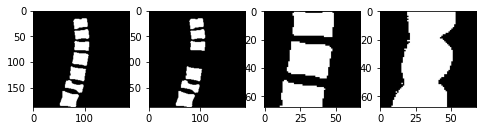


Loss: 0.16412577033042908


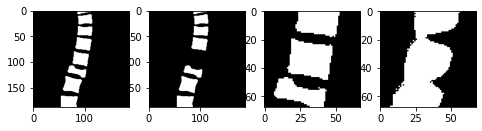


Loss: 0.19458967447280884


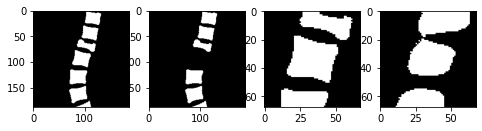


Loss: 0.15127435326576233


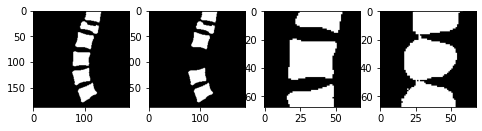


Loss: 0.1560676544904709


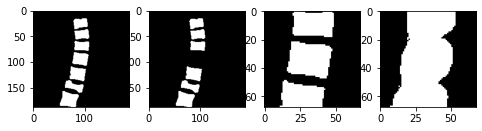


Loss: 0.15860624611377716


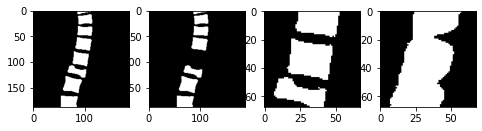


Loss: 0.18151256442070007


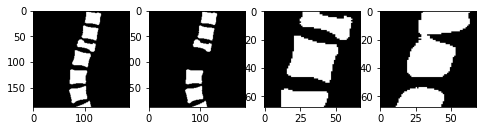


Loss: 0.15611650049686432


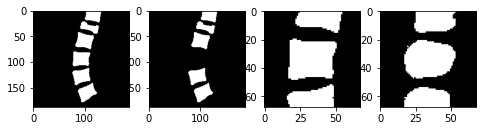


Loss: 0.131614089012146


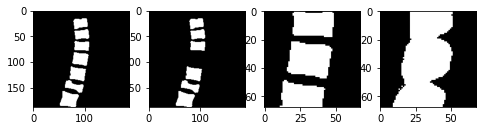


Loss: 0.1663844883441925


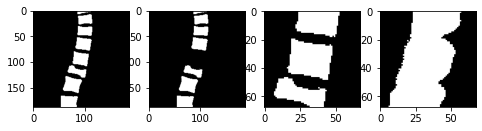


Loss: 0.16761258244514465


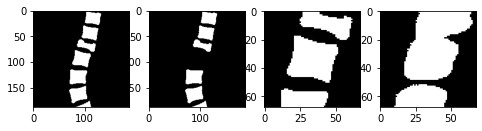


Loss: 0.14727899432182312


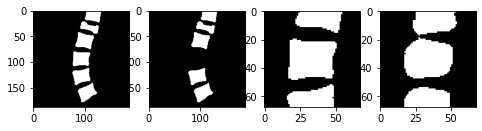


Loss: 0.14068269729614258


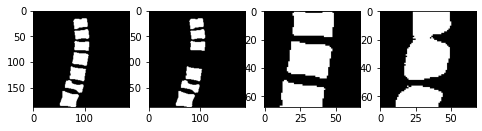


Loss: 0.15147584676742554


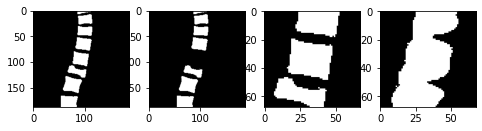


Loss: 0.1732870638370514


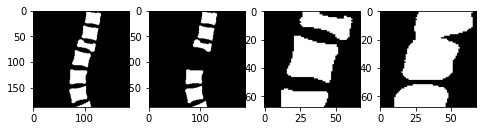


Loss: 0.13919804990291595


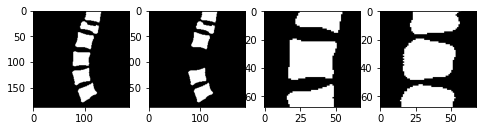


Loss: 0.12768705189228058


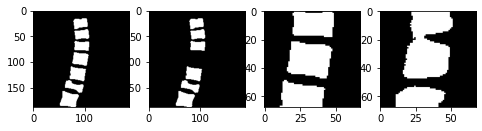


Loss: 0.15358896553516388


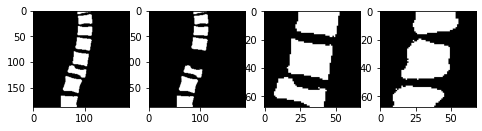


Loss: 0.15490801632404327


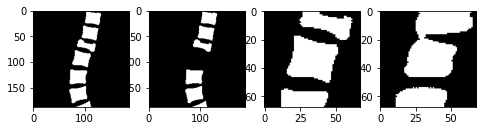


Loss: 0.13805311918258667


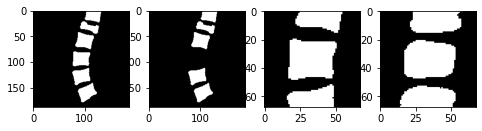


Loss: 0.11892857402563095


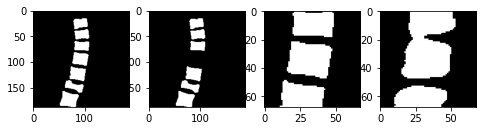


Loss: 0.14373250305652618


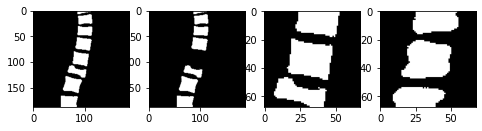


Loss: 0.15486839413642883


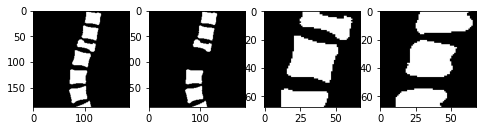


Loss: 0.1296537071466446


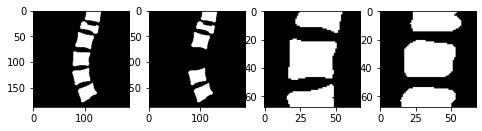


Loss: 0.12829558551311493


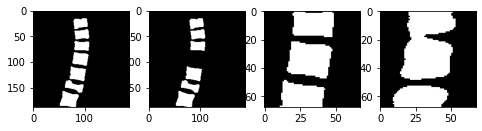


Loss: 0.14351016283035278


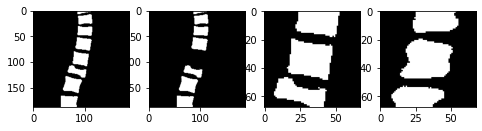


Loss: 0.15529990196228027


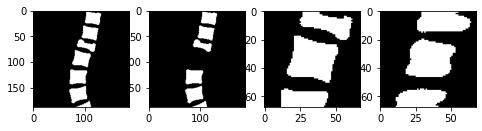


Loss: 0.11936547607183456


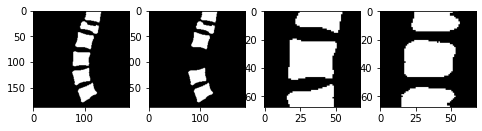


Loss: 0.14068397879600525


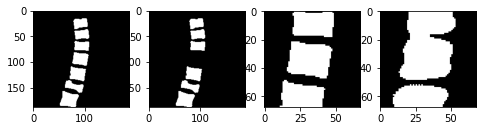


Loss: 0.13699759542942047


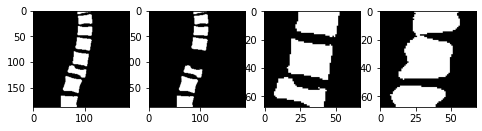


Loss: 0.1558111160993576


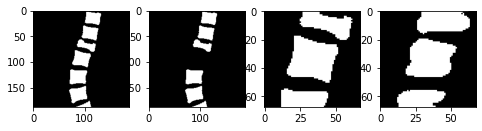


Loss: 0.12850728631019592


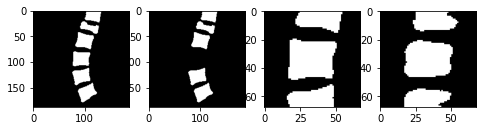


Loss: 0.12488557398319244


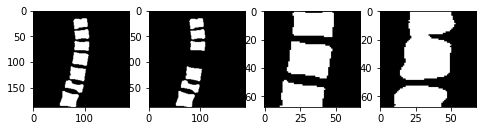


Loss: 0.15521983802318573


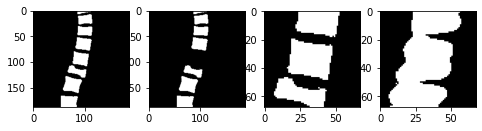


Loss: 0.1445980668067932


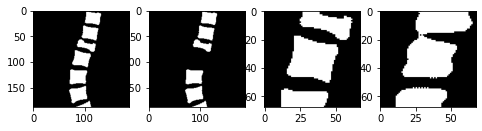


Loss: 0.13703742623329163


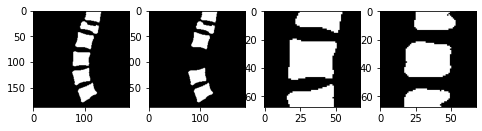


Loss: 0.13237310945987701


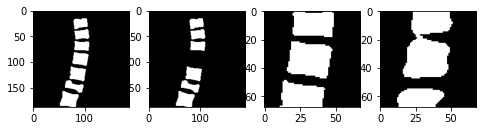


Loss: 0.1357048749923706


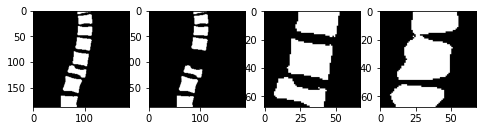


Loss: 0.17253051698207855


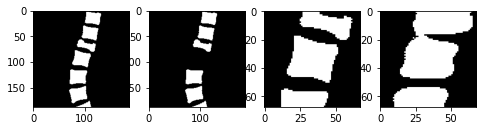


Loss: 0.11829998344182968


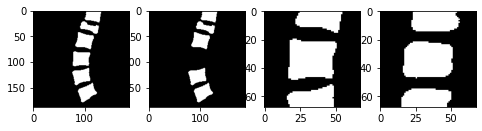


Loss: 0.13244479894638062


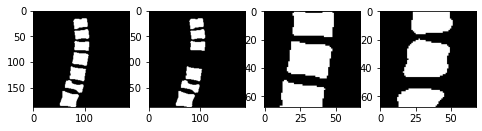


Loss: 0.14697621762752533


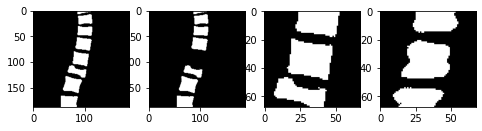


Loss: 0.14059770107269287


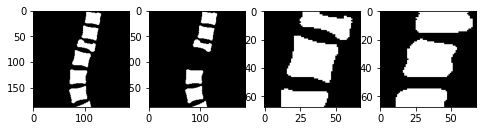


Loss: 0.12996526062488556


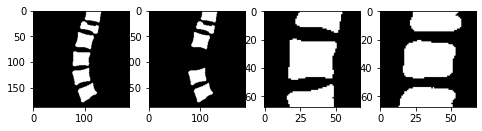


Loss: 0.11503520607948303


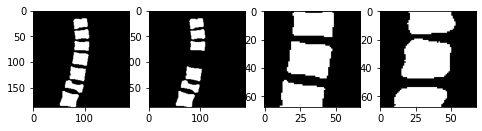


Loss: 0.13493286073207855


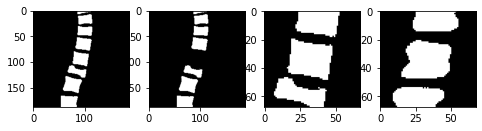


Loss: 0.14298953115940094


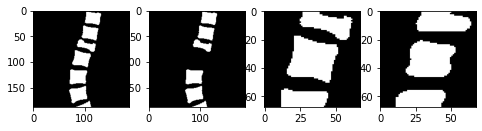


Loss: 0.11670201271772385


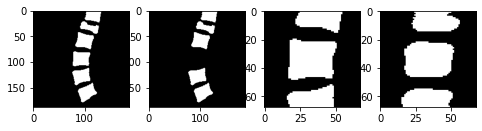


Loss: 0.12683430314064026


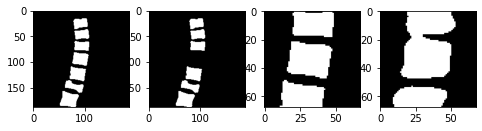


Loss: 0.1341555416584015


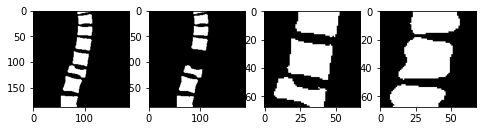


Loss: 0.13426102697849274


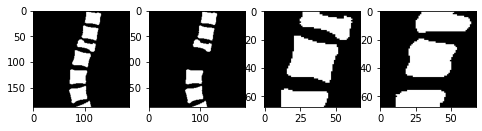


Loss: 0.1277603656053543


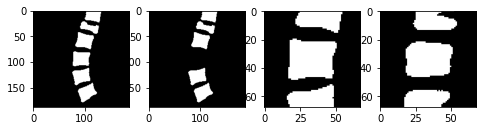


Loss: 0.11525382846593857


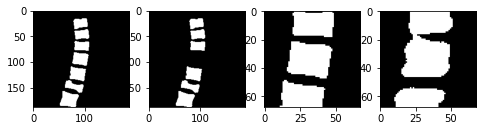


Loss: 0.1325671523809433


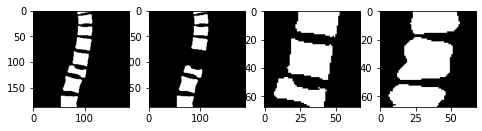


Loss: 0.14021523296833038


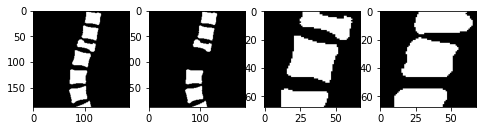


Loss: 0.11297409981489182


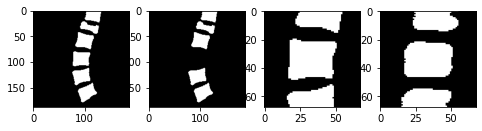


Loss: 0.12442635744810104


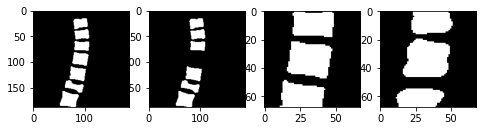


Loss: 0.1284390538930893


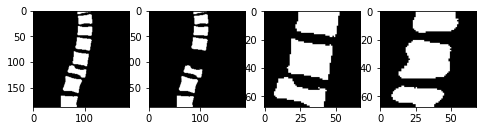


Loss: 0.13791604340076447


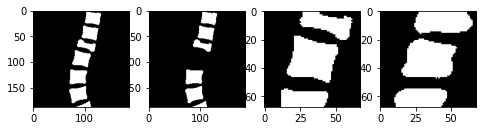


Loss: 0.11950940638780594


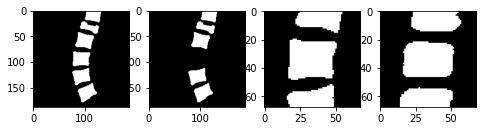


Loss: 0.11103091388940811


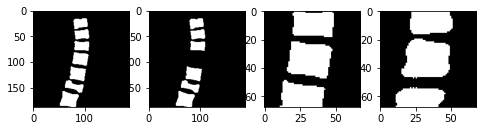


Loss: 0.12950564920902252


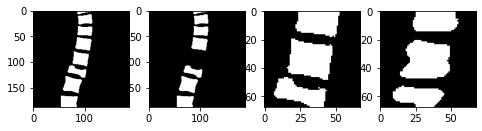


Loss: 0.13118085265159607


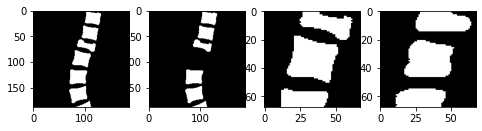


Loss: 0.10859799385070801


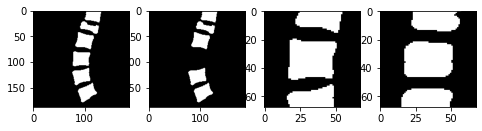


Loss: 0.11302327364683151


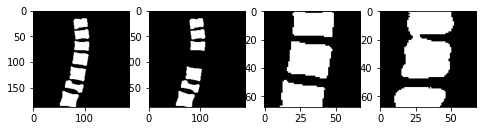


Loss: 0.12208989262580872


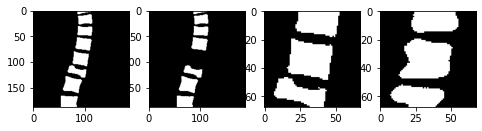


Loss: 0.12614315748214722


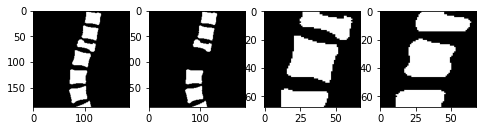


Loss: 0.1083279475569725


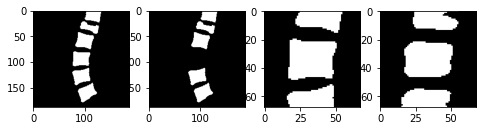


Loss: 0.1130174845457077


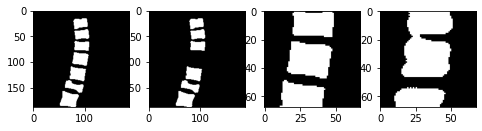


Loss: 0.12204235047101974


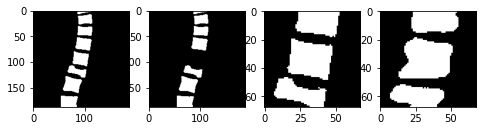


Loss: 0.12281771749258041


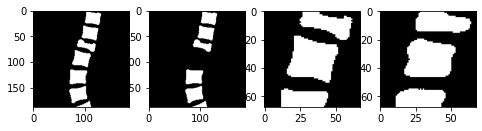


Loss: 0.10953903943300247


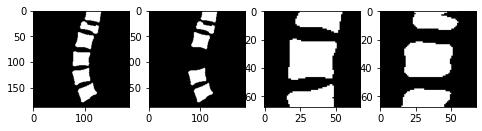


Loss: 0.10892494767904282


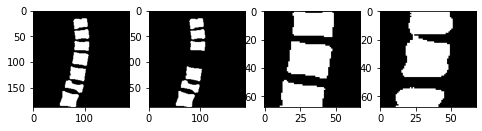


Loss: 0.11819012463092804


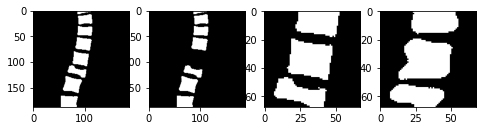


Loss: 0.1279573142528534


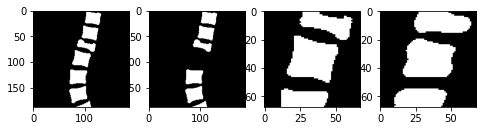


Loss: 0.10694974660873413


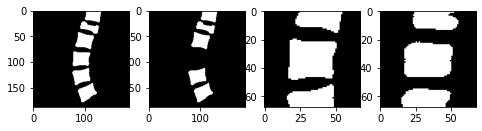


Loss: 0.1140972450375557


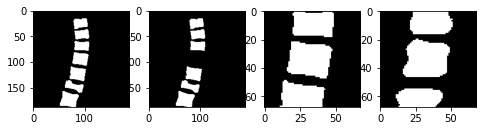


Loss: 0.1145734116435051


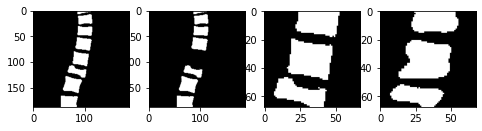


Loss: 0.1314251571893692


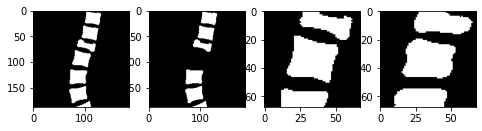


Loss: 0.1066439226269722


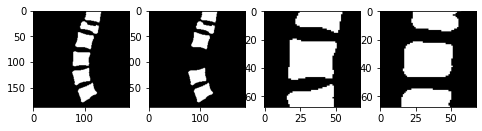


Loss: 0.11336309462785721


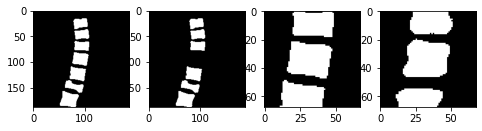


Loss: 0.12053190171718597


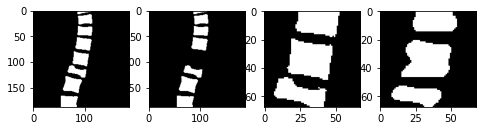


Loss: 0.12153184413909912


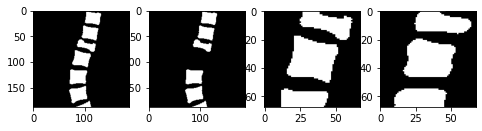


Loss: 0.11348780244588852


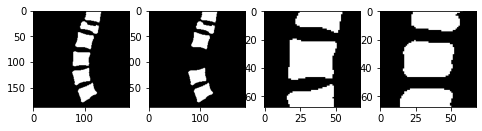


Loss: 0.10541890561580658


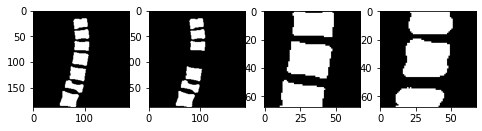


Loss: 0.1242745891213417


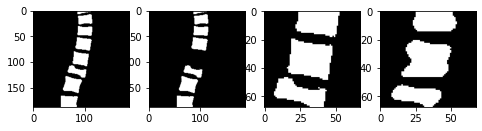


Loss: 0.11919577419757843


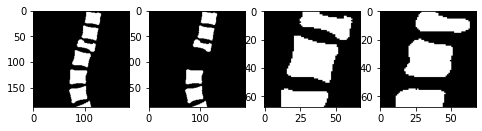


Loss: 0.11076268553733826


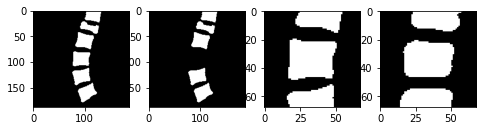


Loss: 0.10886383801698685


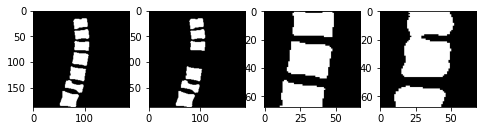


Loss: 0.11400298774242401


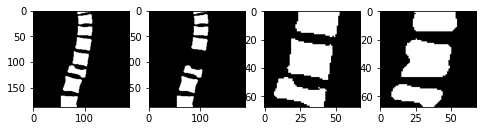


Loss: 0.12925076484680176


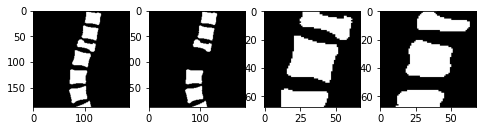


Loss: 0.10178548097610474


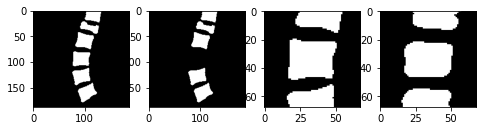


Loss: 0.11868192255496979


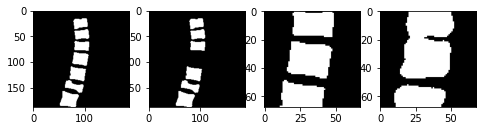


Loss: 0.11267808079719543


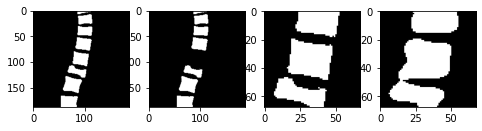


Loss: 0.1266297549009323


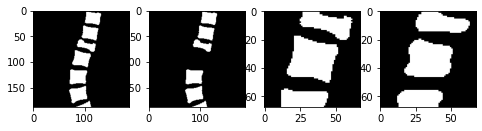


Loss: 0.11550749838352203


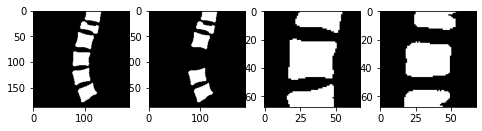


Loss: 0.10141929239034653


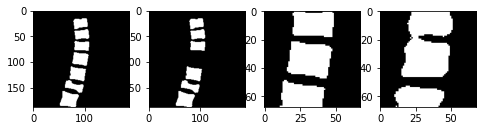


Loss: 0.12563274800777435


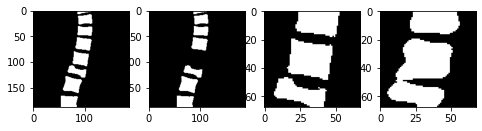


Loss: 0.11934752017259598


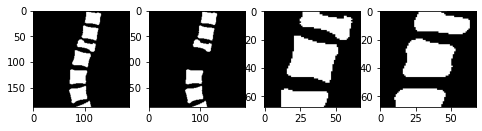


Loss: 0.11109656095504761


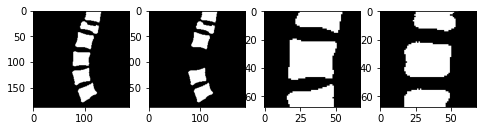


Loss: 0.11700084060430527


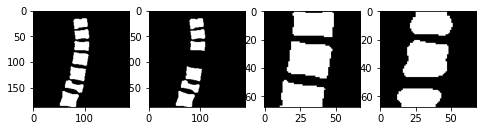


Loss: 0.1076890230178833


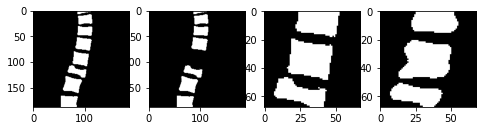


Loss: 0.1314939558506012


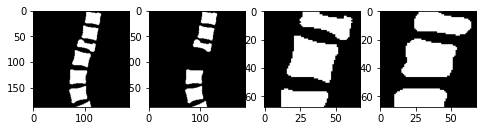


Loss: 0.10520311444997787


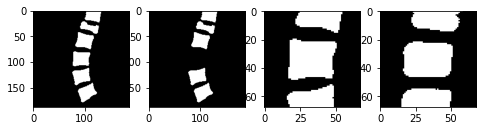


Loss: 0.10486739128828049


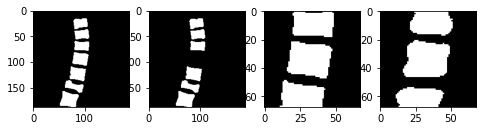


Loss: 0.12037836015224457


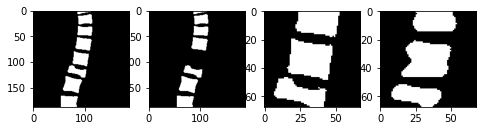


Loss: 0.11269626766443253


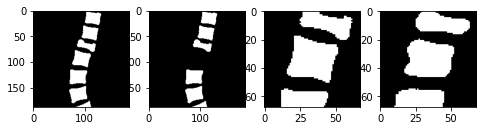


Loss: 0.10626540333032608


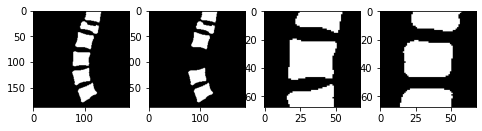


Loss: 0.10306756943464279


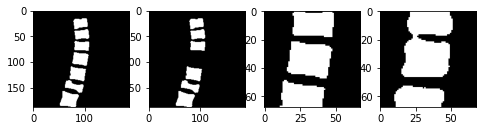


Loss: 0.10746155679225922


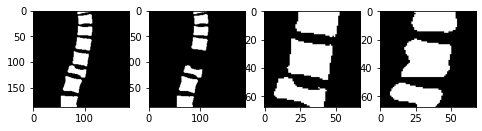


Loss: 0.11819913238286972


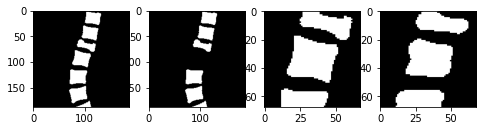


Loss: 0.09931044280529022


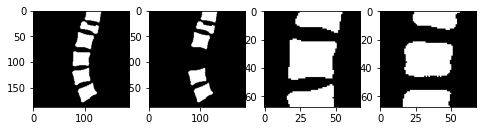


Loss: 0.10298041254281998


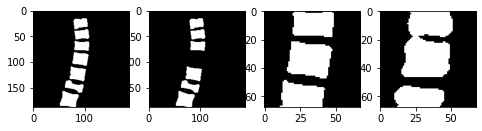


Loss: 0.10939189791679382


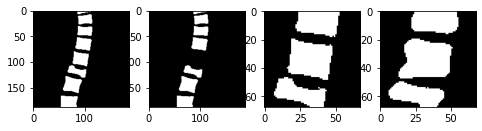


Loss: 0.11031096428632736


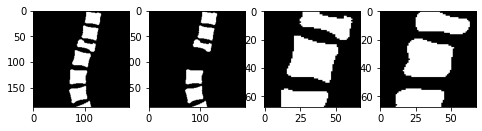


Loss: 0.10166013240814209


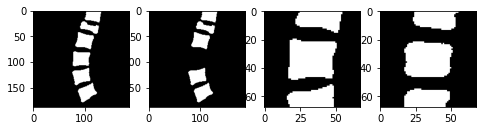


Loss: 0.10284257680177689


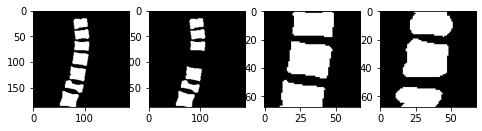


Loss: 0.10309349745512009


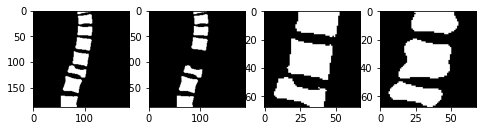


Loss: 0.12093515694141388


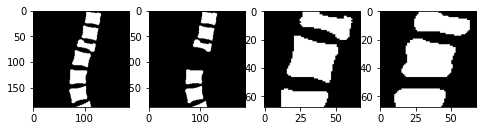


Loss: 0.09697362780570984


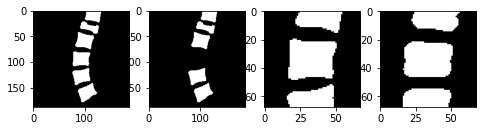


Loss: 0.10276860743761063


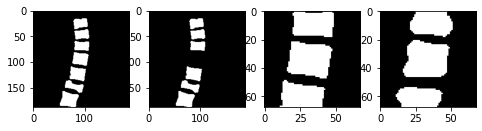


Loss: 0.10744479298591614


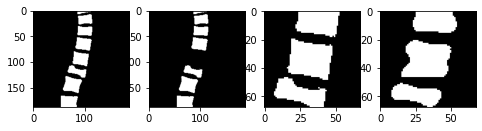


Loss: 0.10818500816822052


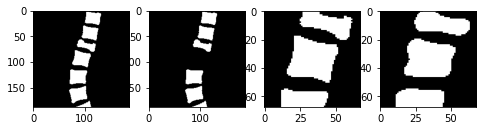


Loss: 0.10301671922206879


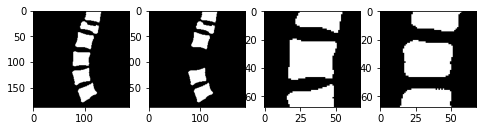


Loss: 0.09418350458145142


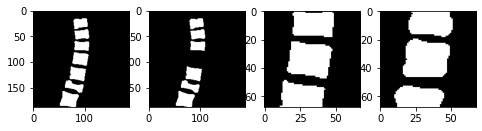


Loss: 0.10509195178747177


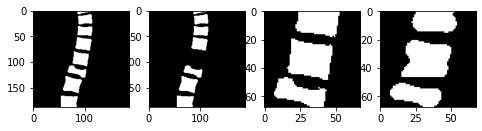


Loss: 0.109592005610466


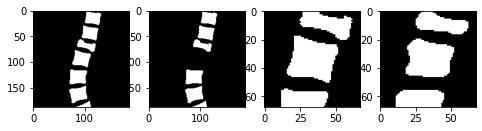


Loss: 0.0941719114780426


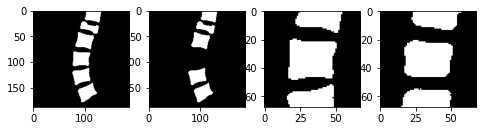


Loss: 0.10035793483257294


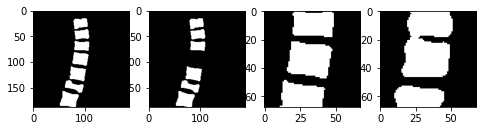


Loss: 0.09974876046180725


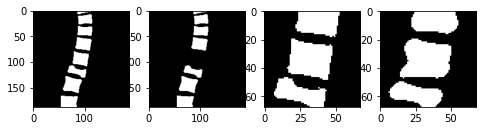


Loss: 0.10699622333049774


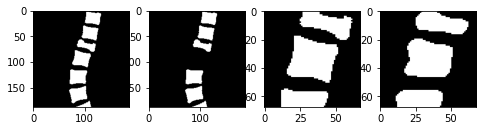


Loss: 0.09770311415195465


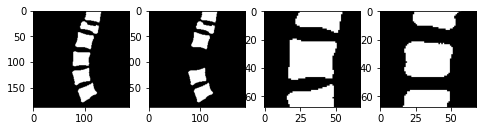


Loss: 0.09353240579366684


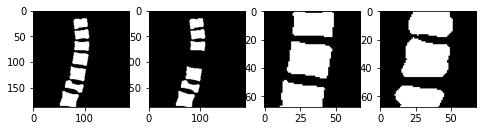


Loss: 0.10174605995416641


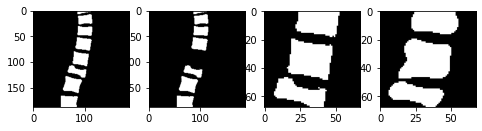


Loss: 0.10556647181510925


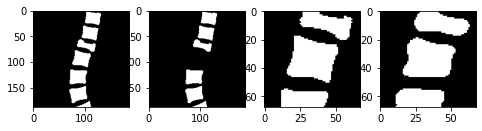


Loss: 0.09432794898748398


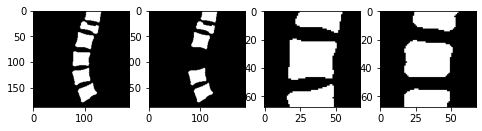


Loss: 0.09849153459072113


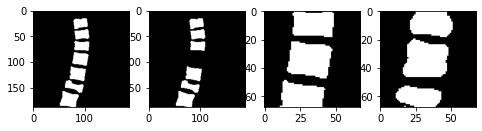


Loss: 0.09629646688699722


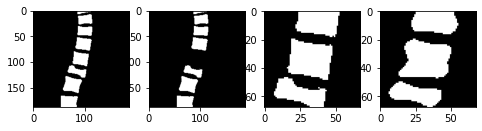


Loss: 0.11072162538766861


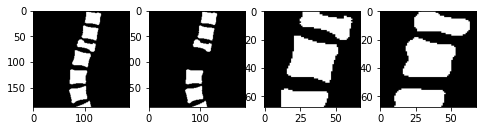


Loss: 0.09081289917230606


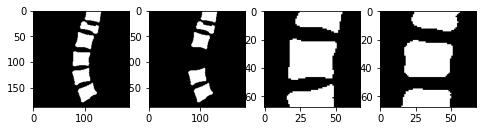


Loss: 0.09709703177213669


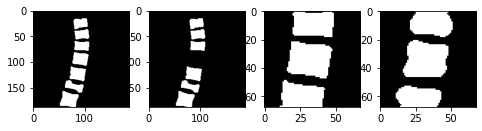


Loss: 0.10127511620521545


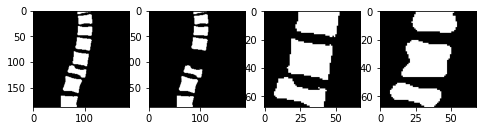


Loss: 0.10193265974521637


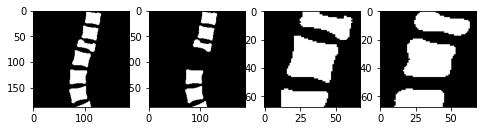


Loss: 0.09595714509487152


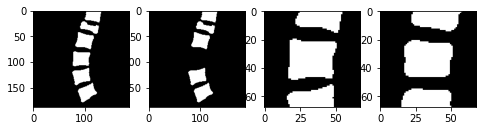


Loss: 0.09032988548278809


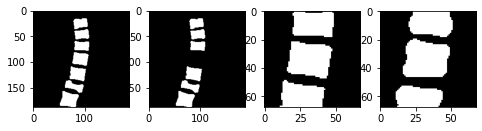


Loss: 0.10058464854955673


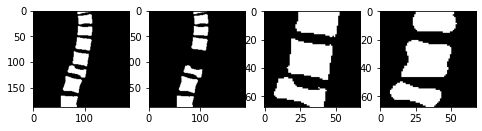


Loss: 0.10105718672275543


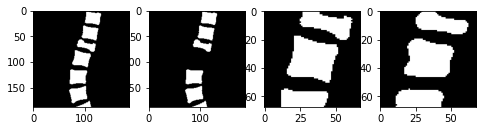


Loss: 0.09117712080478668


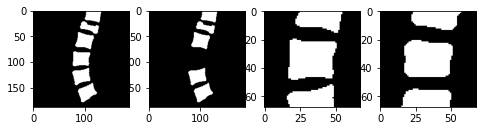


Loss: 0.0958915576338768


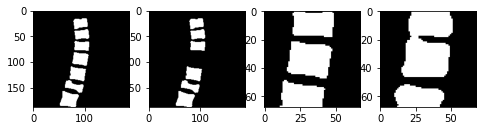


Loss: 0.09332917630672455


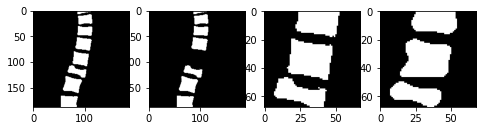


Loss: 0.10402028262615204


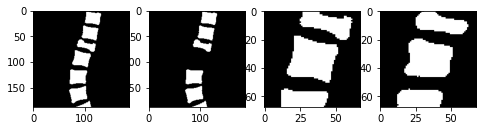


Loss: 0.08897063136100769


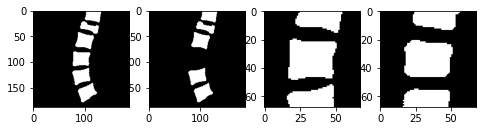


Loss: 0.09264126420021057


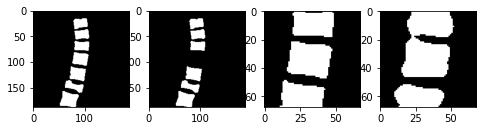


Loss: 0.09593949466943741


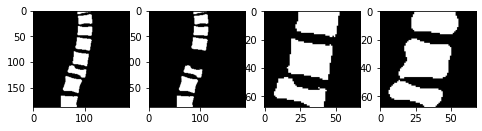


Loss: 0.09961343556642532


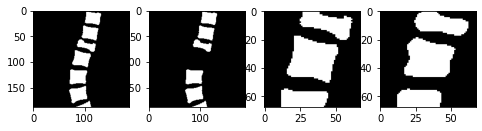


Loss: 0.09294544905424118


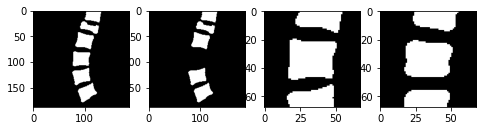


Loss: 0.08746381103992462


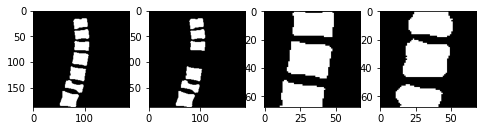


Loss: 0.09788569808006287


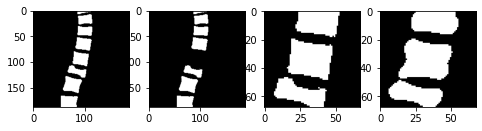


Loss: 0.09876589477062225


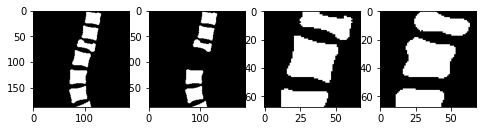


Loss: 0.08855841308832169


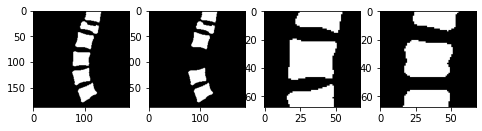


Loss: 0.09575911611318588


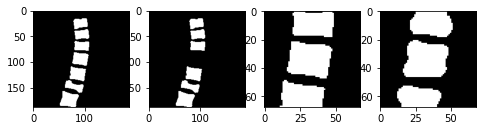


Loss: 0.09214722365140915


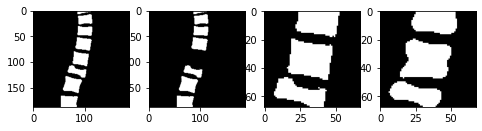


Loss: 0.10555561631917953


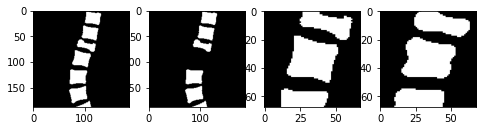


Loss: 0.08505218476057053


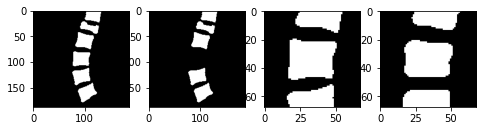


Loss: 0.09639856964349747


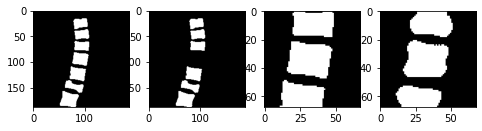


Loss: 0.09613277018070221


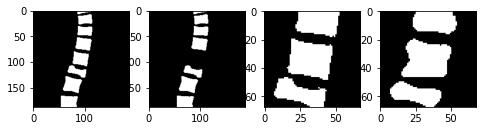


Loss: 0.09754381328821182


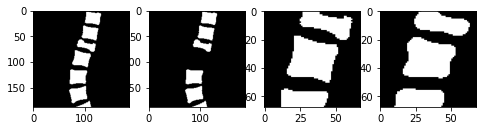


Loss: 0.09167726337909698


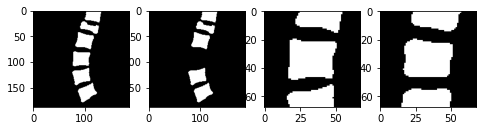


Loss: 0.08728650212287903


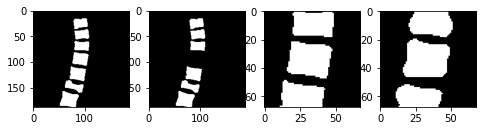


Loss: 0.1009756326675415


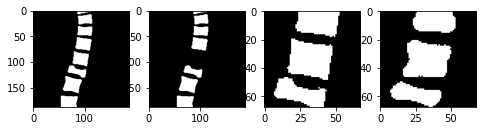


Loss: 0.095150887966156


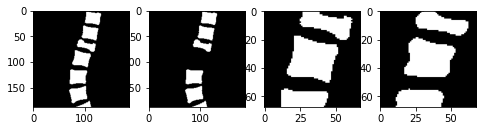


Loss: 0.0950603038072586


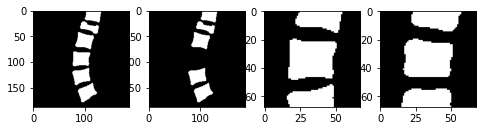


Loss: 0.0926230177283287


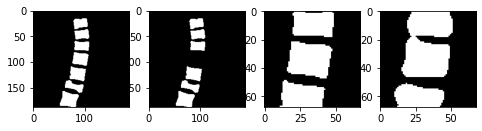


Loss: 0.0936657041311264


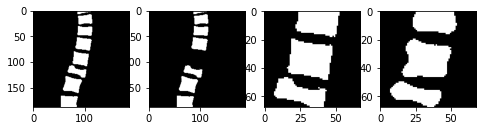


Loss: 0.1116909310221672


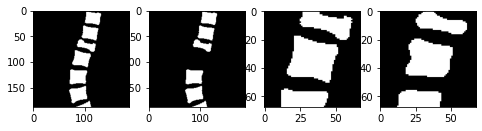


Loss: 0.08492481708526611


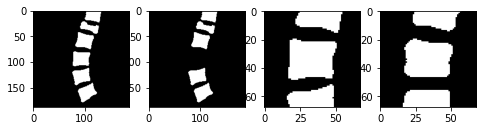


Loss: 0.10792804509401321


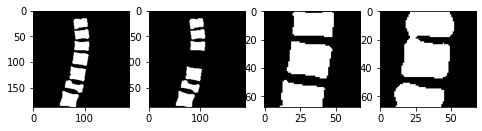


Loss: 0.09512998163700104


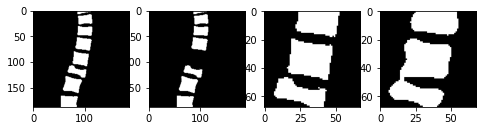


Loss: 0.10392040759325027


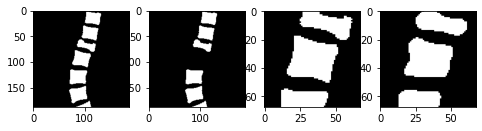


Loss: 0.10265802592039108


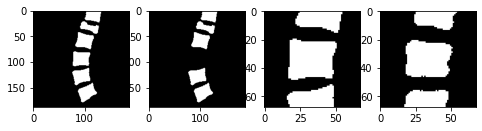


Loss: 0.08511967957019806


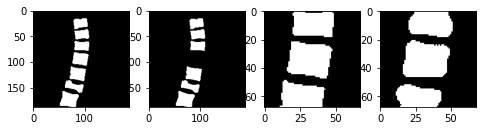


Loss: 0.10215900093317032


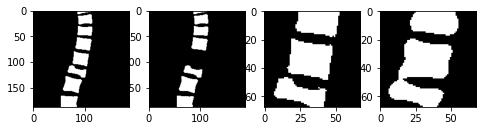


Loss: 0.10360006242990494


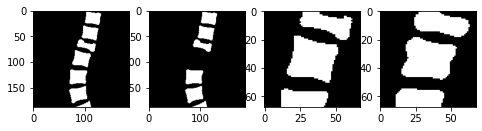


Loss: 0.08636011183261871


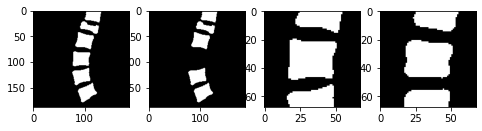


Loss: 0.09862679243087769


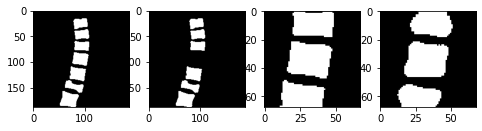


Loss: 0.09393884241580963


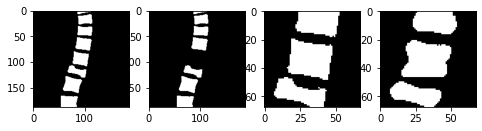


Loss: 0.0959419459104538


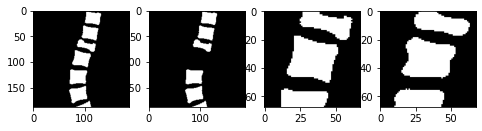


Loss: 0.0891181007027626


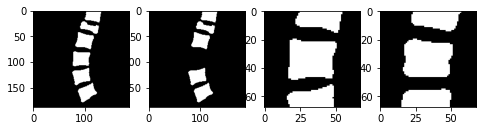


Loss: 0.0849582627415657


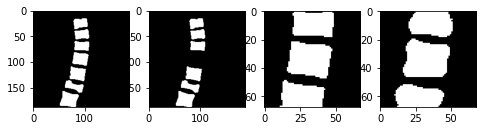


Loss: 0.0961804986000061


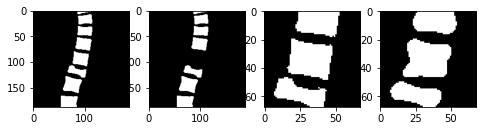


Loss: 0.09774070233106613


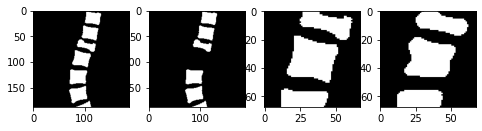


Loss: 0.08077654242515564


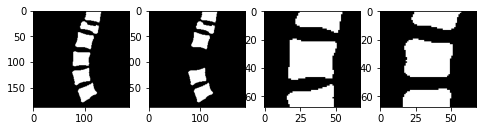


Loss: 0.09526920318603516


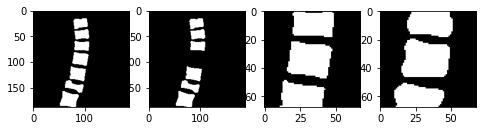


Loss: 0.08835212886333466


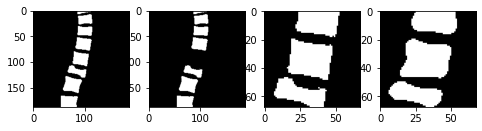


Loss: 0.09288343787193298


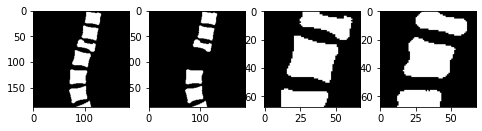


Loss: 0.08665350824594498


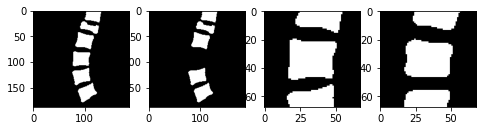


Loss: 0.08210228383541107


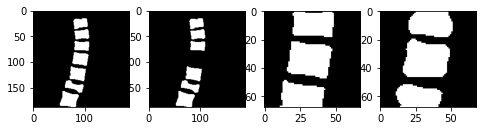


Loss: 0.0884917601943016


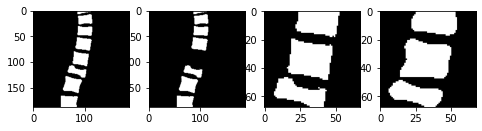


Loss: 0.09219023585319519


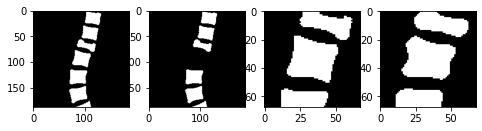


Loss: 0.0805317685008049


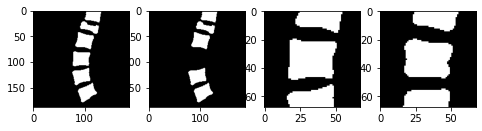


Loss: 0.08537965267896652


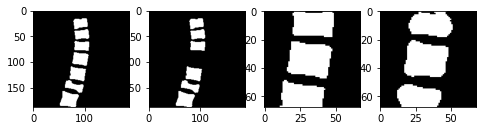


Loss: 0.08766301721334457


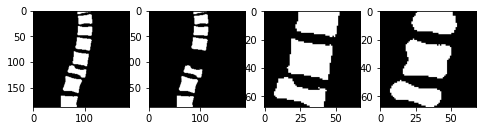


Loss: 0.08981151133775711


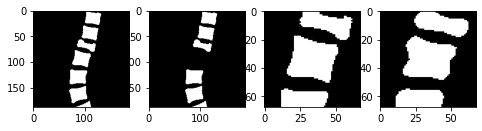


Loss: 0.0818634182214737


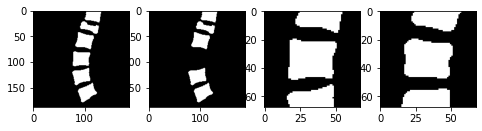


Loss: 0.07861209660768509


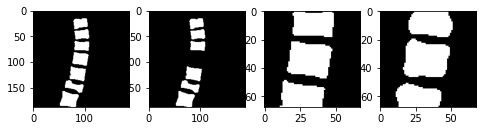


Loss: 0.08812705427408218


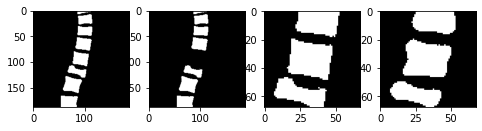


Loss: 0.08602048456668854


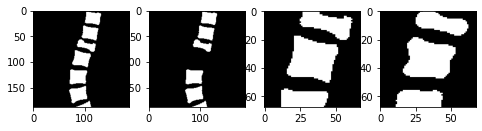


Loss: 0.08038884401321411


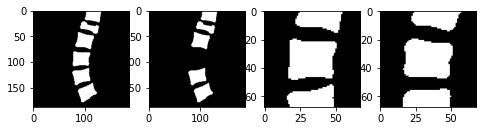


Loss: 0.08350929617881775


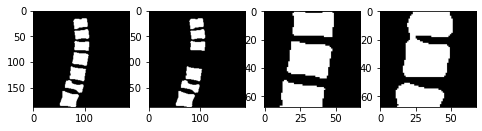


Loss: 0.08266329765319824


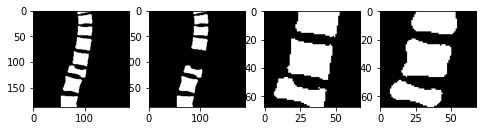


Loss: 0.08817379921674728


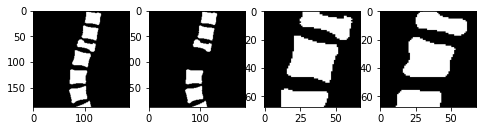


Loss: 0.07790614664554596


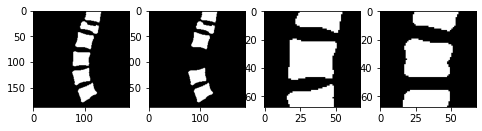


Loss: 0.08153627067804337


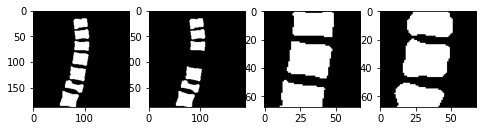


Loss: 0.08196789026260376


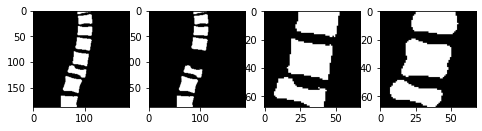


Loss: 0.0859551653265953


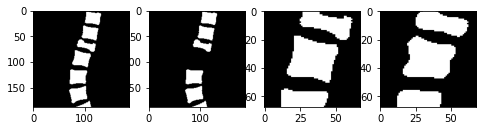


Loss: 0.07916916906833649


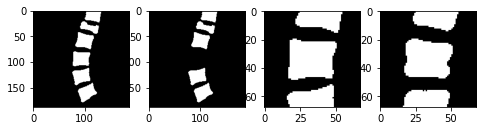


Loss: 0.07634924352169037


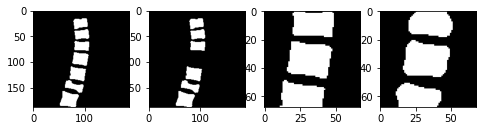


Loss: 0.08319239318370819


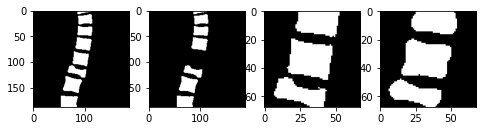


Loss: 0.08607473224401474


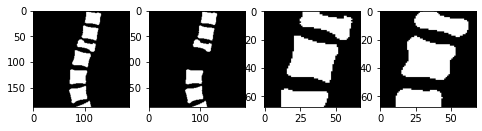


Loss: 0.07790122181177139


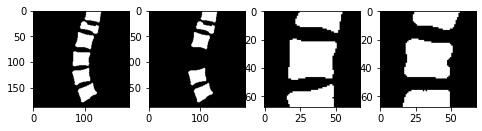


Loss: 0.0818941742181778


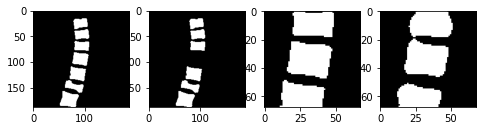


Loss: 0.08086418360471725


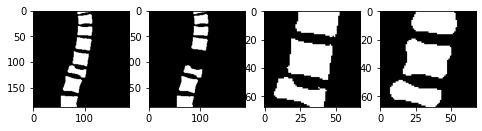


Loss: 0.09092641621828079


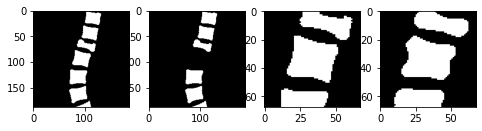


Loss: 0.07540174573659897


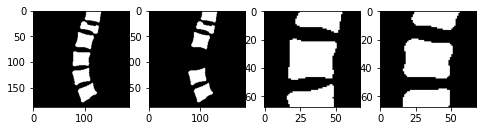


Loss: 0.08126483857631683


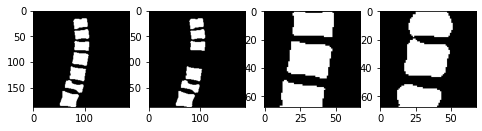


Loss: 0.08621438592672348


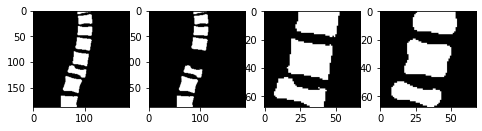


Loss: 0.082852303981781


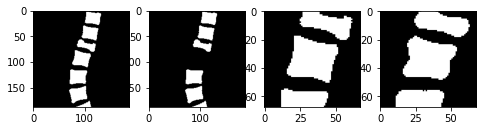


Loss: 0.0810438022017479


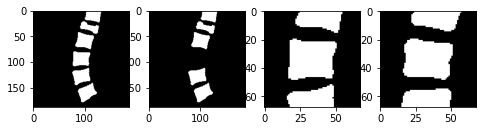


Loss: 0.07682943344116211


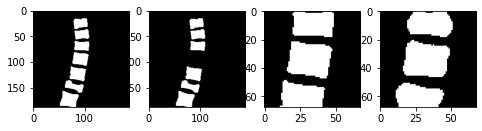


Loss: 0.09047753363847733


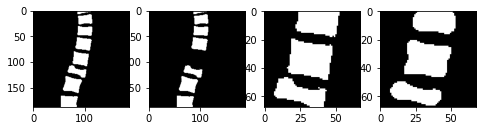


Loss: 0.087367482483387


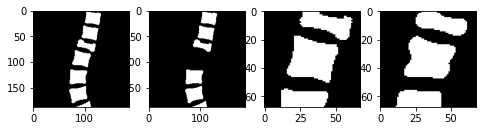


Loss: 0.07998167723417282


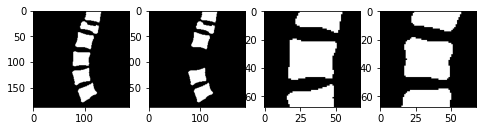


Loss: 0.0930696651339531


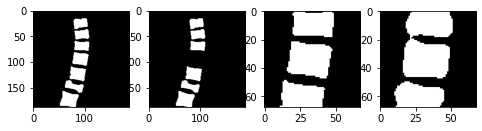


Loss: 0.08321508020162582


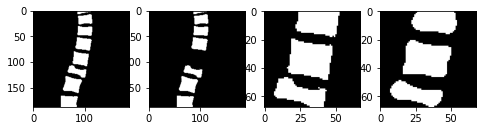


Loss: 0.10052596777677536


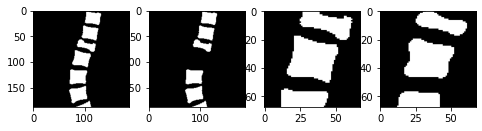


Loss: 0.08016398549079895


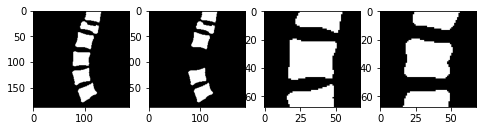


Loss: 0.08771594613790512


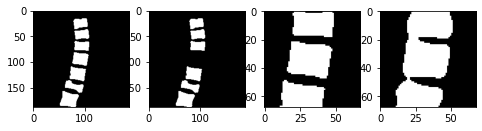


Loss: 0.09621410071849823


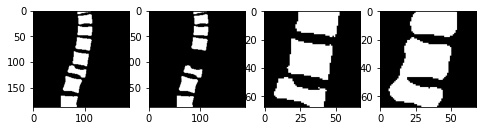


Loss: 0.08641661703586578


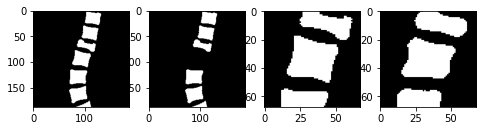


Loss: 0.09138477593660355


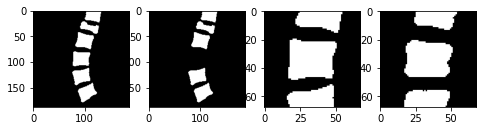


Loss: 0.0845400020480156


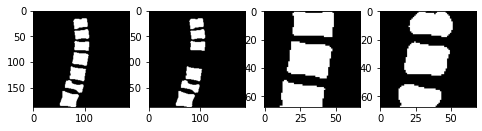


Loss: 0.08216918259859085


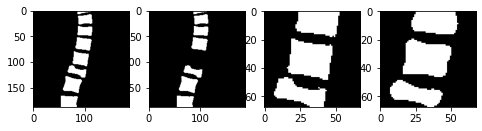


Loss: 0.09772409498691559


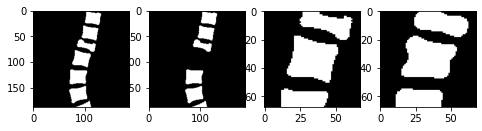


Loss: 0.07486255466938019


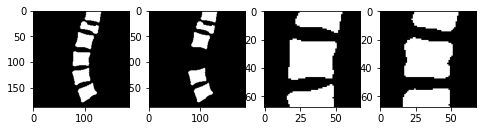


Loss: 0.08057251572608948


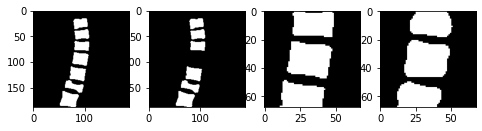


Loss: 0.08789067715406418


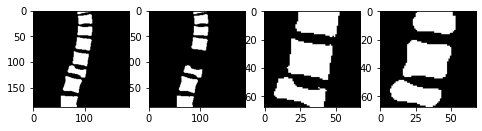


Loss: 0.08345726877450943


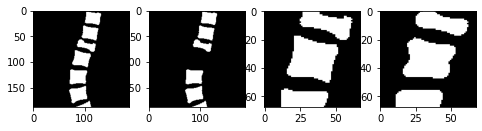


Loss: 0.077076256275177


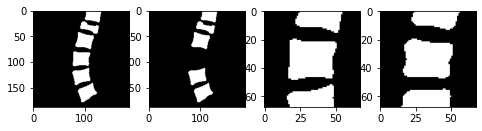


Loss: 0.07831799238920212


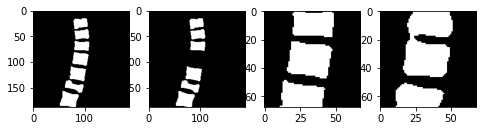


Loss: 0.08173087239265442


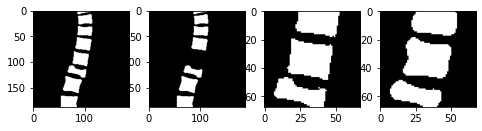


Loss: 0.08811870962381363


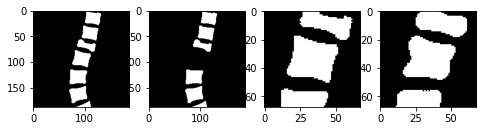


Loss: 0.07197786122560501


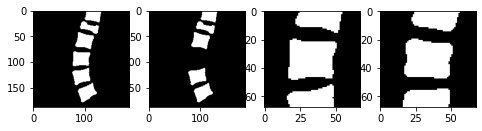


Loss: 0.08235210180282593


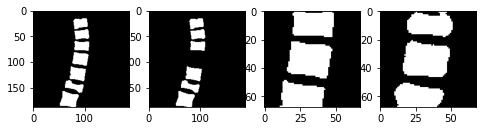


Loss: 0.08230824768543243


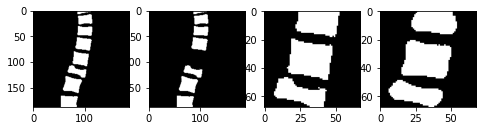


Loss: 0.08003520965576172


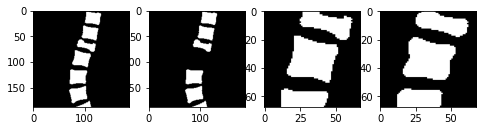


Loss: 0.07646159827709198


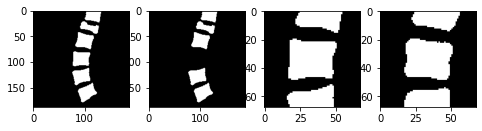


Loss: 0.07594925165176392


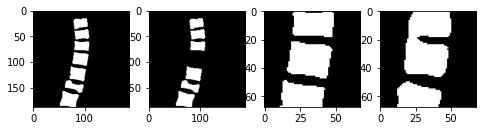


Loss: 0.0798533633351326


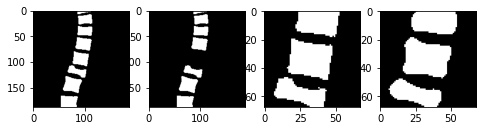


Loss: 0.08336727321147919


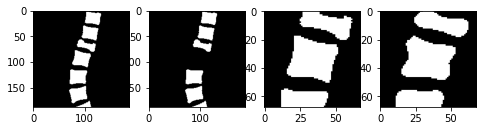


Loss: 0.07335424423217773


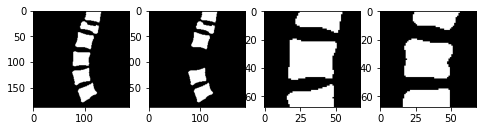


Loss: 0.07632312923669815


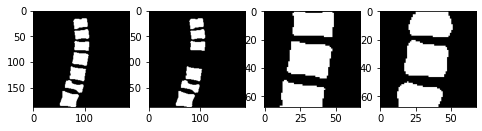


Loss: 0.07894640415906906


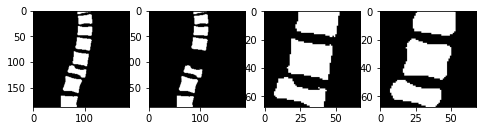


Loss: 0.07910013198852539


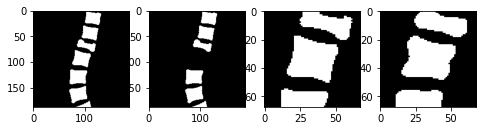


Loss: 0.07361333072185516


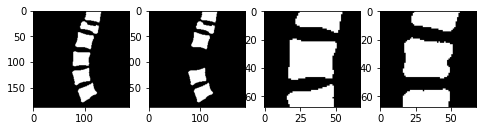


Loss: 0.07131854444742203


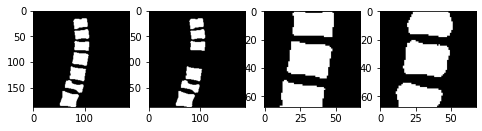


Loss: 0.07944918423891068


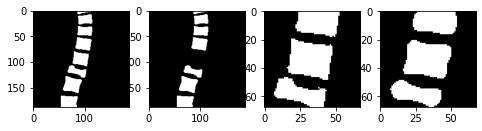


Loss: 0.08085137605667114


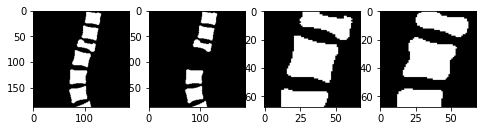


Loss: 0.07075633853673935


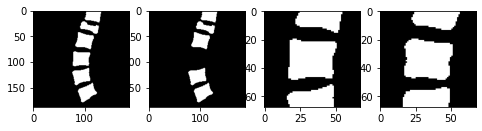


Loss: 0.07391677796840668


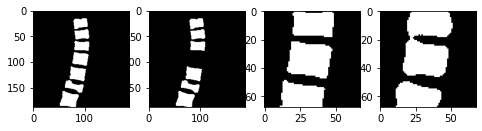


Loss: 0.07793885469436646


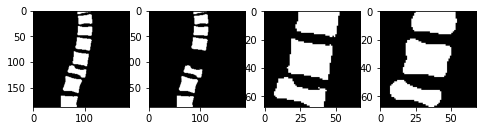


Loss: 0.0780925378203392


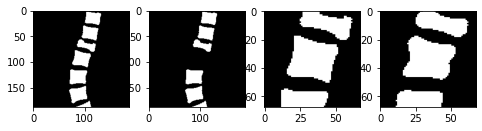


Loss: 0.0719396248459816


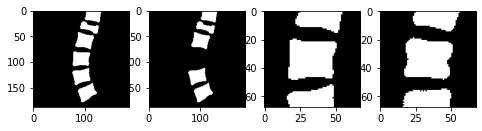


Loss: 0.07430966943502426


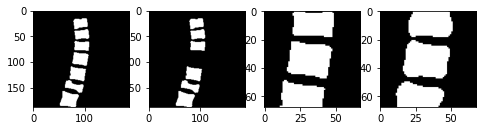


Loss: 0.07681567966938019


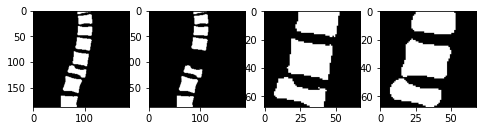


Loss: 0.08164291083812714


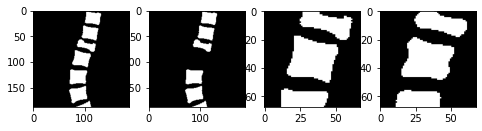


Loss: 0.07252518087625504


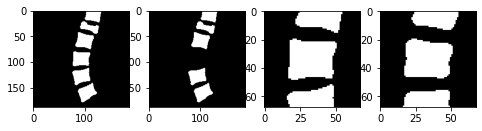


Loss: 0.07274360209703445


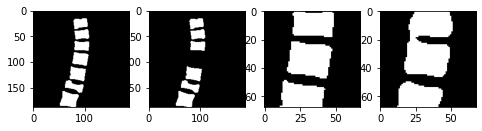


Loss: 0.07743450254201889


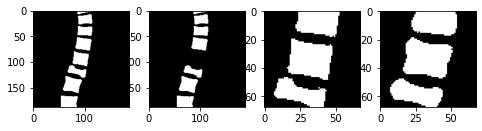


Loss: 0.07946726679801941


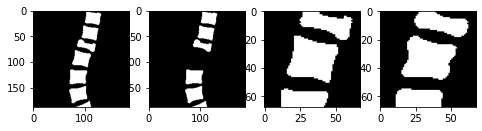


Loss: 0.06862074136734009


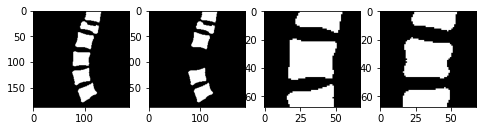


Loss: 0.07138705998659134


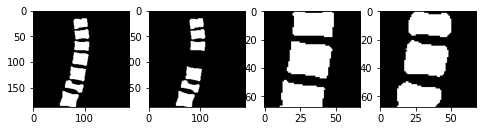


Loss: 0.07586254179477692


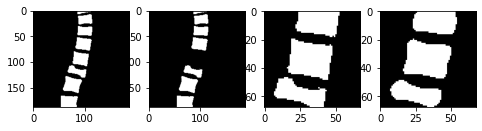


Loss: 0.07712328433990479


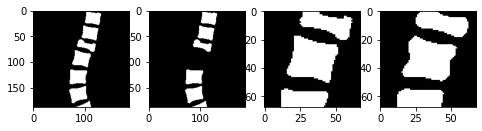


Loss: 0.0703357458114624


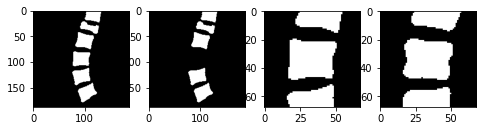


Loss: 0.07169140130281448


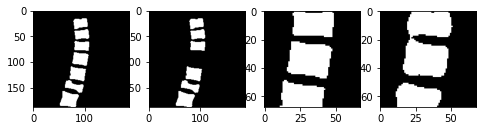


Loss: 0.07837070524692535


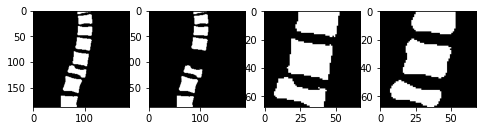


Loss: 0.07388105243444443


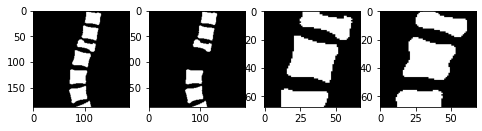


Loss: 0.06887304037809372


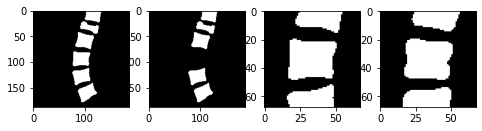


Loss: 0.07443825900554657


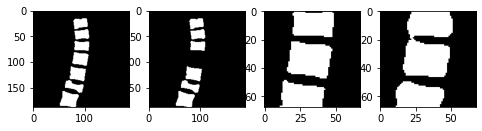


Loss: 0.0735492929816246


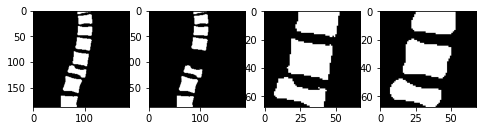


Loss: 0.07949557900428772


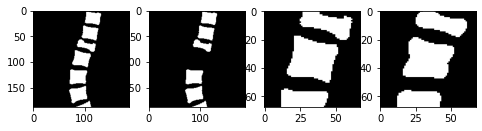


Loss: 0.06829271465539932


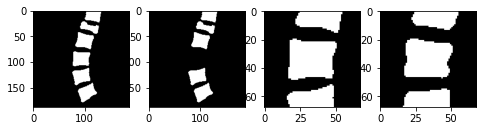


Loss: 0.07007859647274017


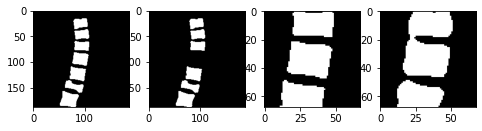


Loss: 0.07627452909946442


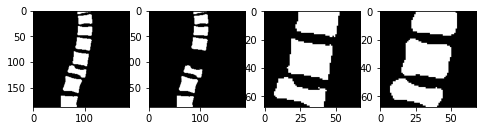


Loss: 0.07432132959365845


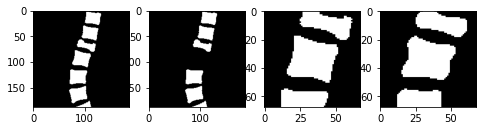


Loss: 0.06954636424779892


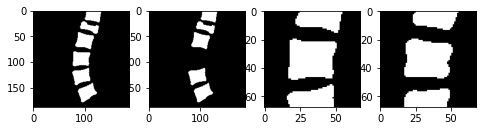


Loss: 0.06931881606578827


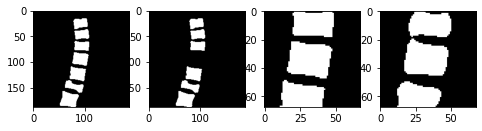


Loss: 0.07196997851133347


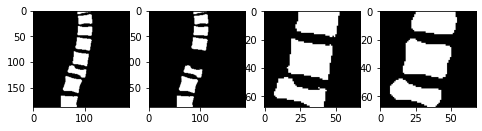


Loss: 0.08097510784864426


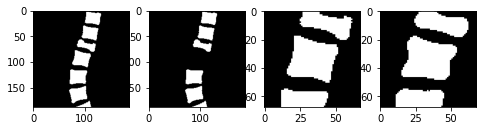


Loss: 0.06529631465673447


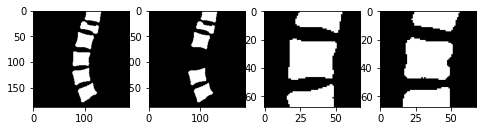


Loss: 0.07113136351108551


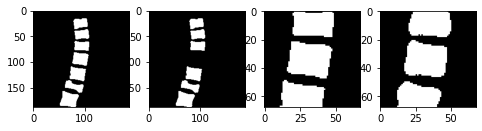


Loss: 0.07711681723594666


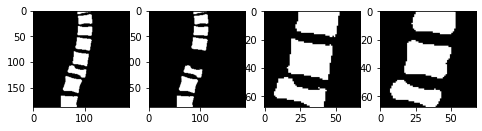


Loss: 0.07504745572805405


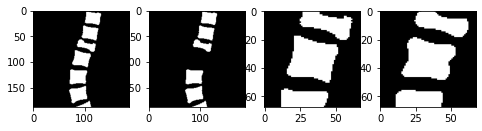


Loss: 0.06960678100585938


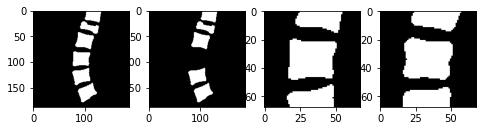


Loss: 0.07150004804134369


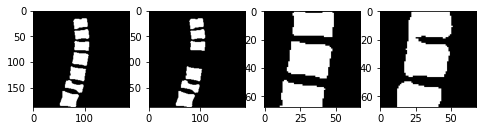


Loss: 0.077477365732193


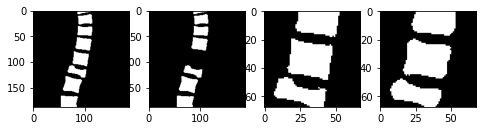


Loss: 0.07403615117073059


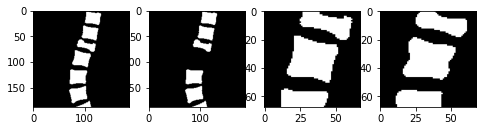


Loss: 0.07021769881248474


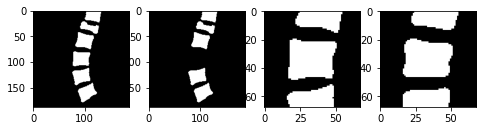


Loss: 0.07050912082195282


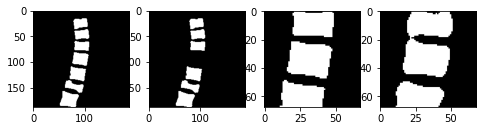


Loss: 0.0745542123913765


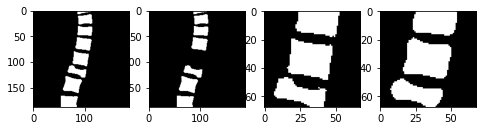


Loss: 0.08805423229932785


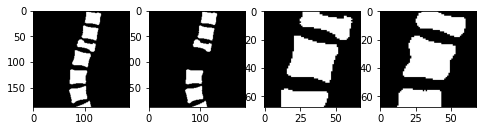


Loss: 0.06403949856758118


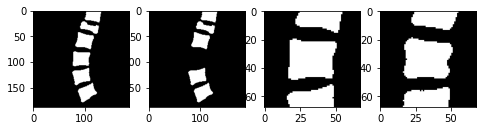


Loss: 0.09053876250982285


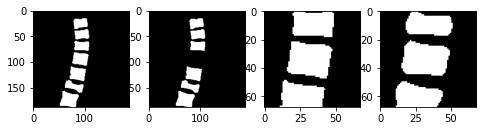


Loss: 0.07476654648780823


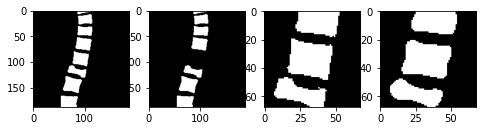


Loss: 0.0808878093957901


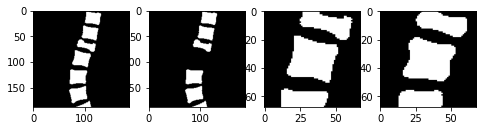


Loss: 0.07842263579368591


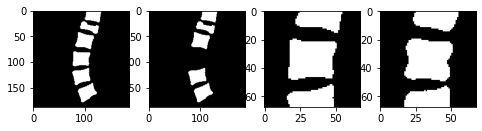


Loss: 0.06844700872898102


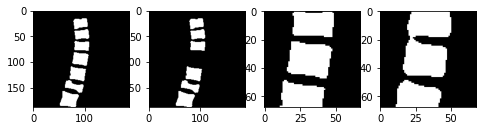


Loss: 0.08260063827037811


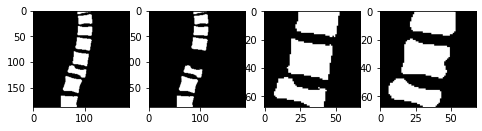


Loss: 0.0946548581123352


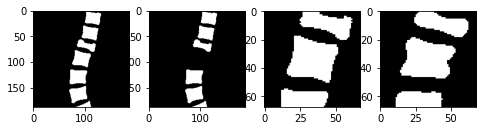


Loss: 0.07769942283630371


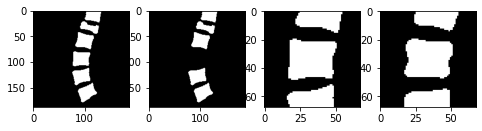


Loss: 0.09423740953207016


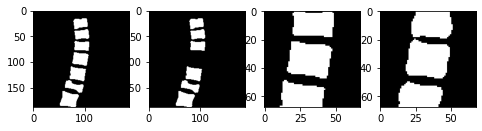


Loss: 0.08262409269809723


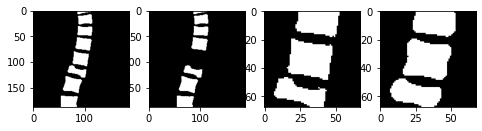


Loss: 0.08835157006978989


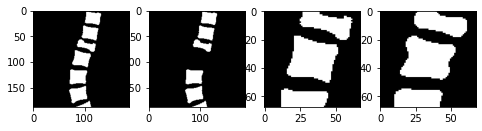


Loss: 0.07680848985910416


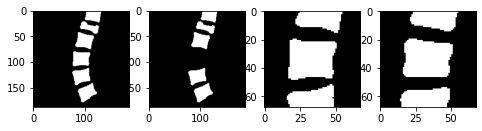


Loss: 0.07034751027822495


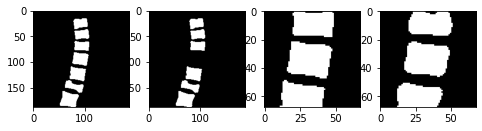


Loss: 0.08872497081756592


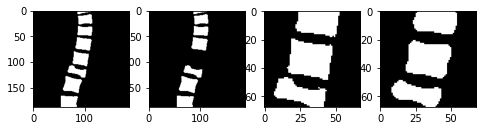


Loss: 0.08409080654382706


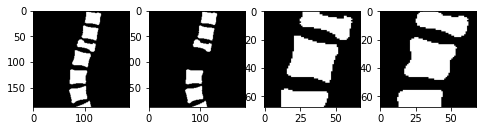


Loss: 0.06805597245693207


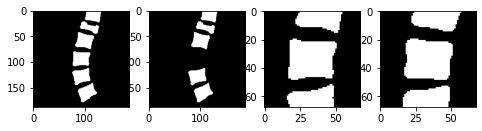


Loss: 0.08073113113641739


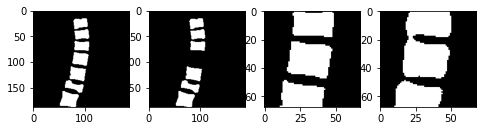


Loss: 0.07928186655044556


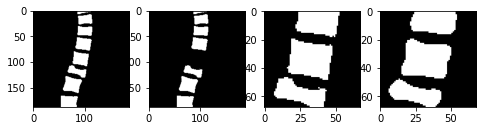


Loss: 0.07333313673734665


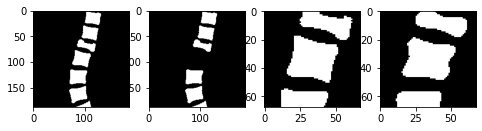


Loss: 0.07094308733940125


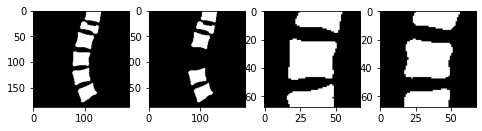


Loss: 0.07402463257312775


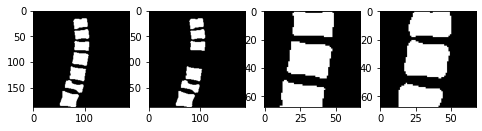


Loss: 0.07316232472658157


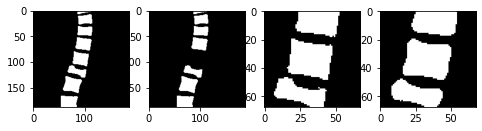


Loss: 0.07315077632665634


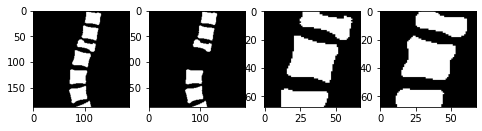


Loss: 0.06459172815084457


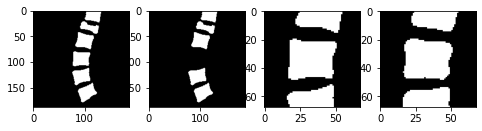


Loss: 0.06875080615282059


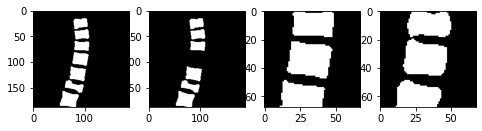


Loss: 0.07545026391744614


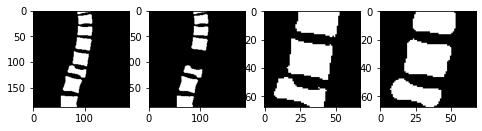


Loss: 0.07512044161558151


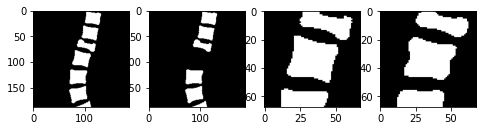


Loss: 0.06495177745819092


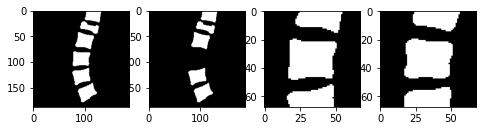


Loss: 0.06823616474866867


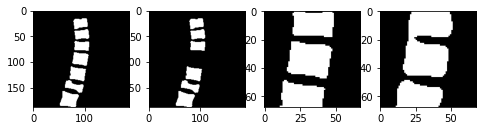


Loss: 0.07133131474256516


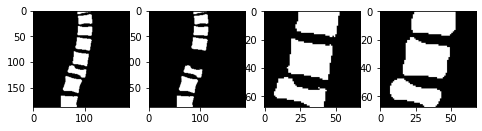


Loss: 0.07473186403512955


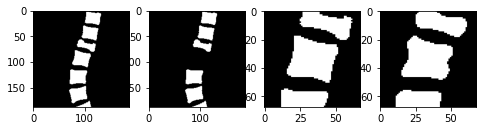


Loss: 0.06475500762462616


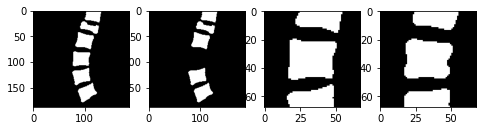


Loss: 0.06936022639274597


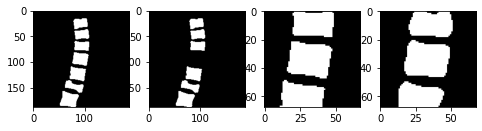


Loss: 0.07081622630357742


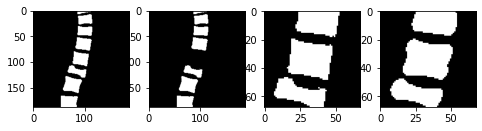


Loss: 0.07044433802366257


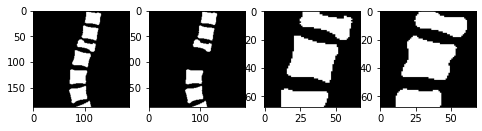


Loss: 0.0640287771821022


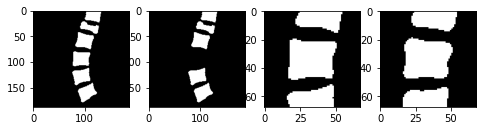


Loss: 0.06601589173078537


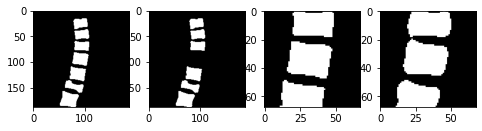


Loss: 0.07096154987812042


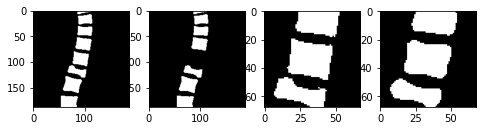


Loss: 0.07702166587114334


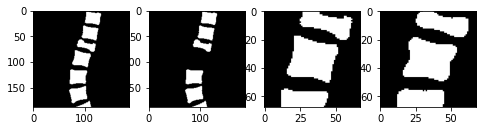


Loss: 0.06235179305076599


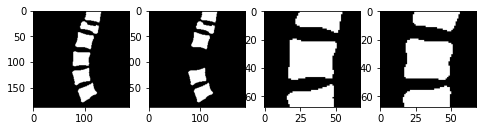


Loss: 0.06537649780511856


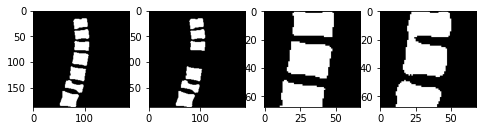


Loss: 0.07284817844629288


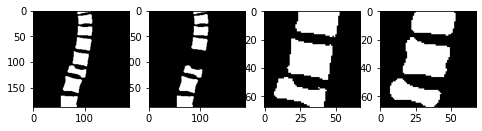


Loss: 0.06737349182367325


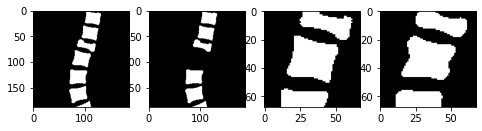


Loss: 0.062648244202137


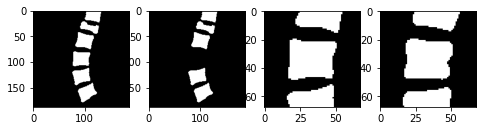


Loss: 0.07028068602085114


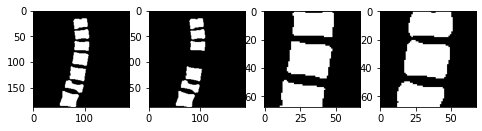


Loss: 0.06818931549787521


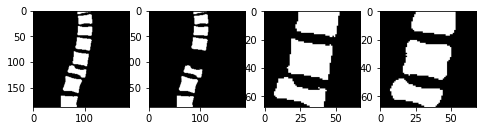


Loss: 0.07092370092868805


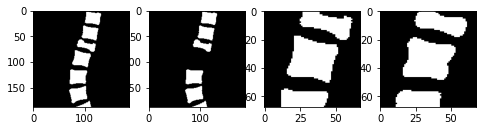


Loss: 0.06284473091363907


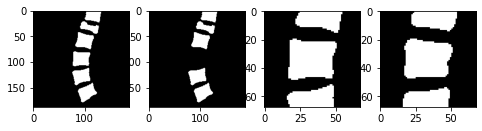


Loss: 0.06170061230659485


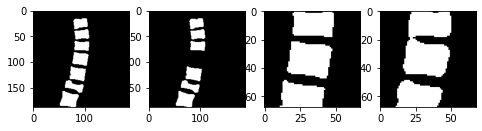


Loss: 0.06912708282470703


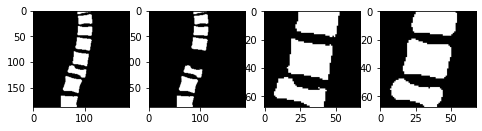


Loss: 0.069725900888443


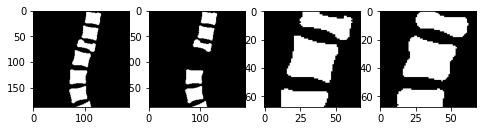


Loss: 0.05914612114429474


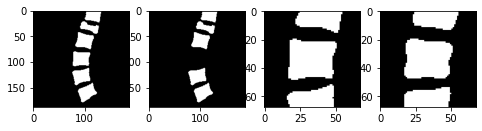


Loss: 0.06507647037506104


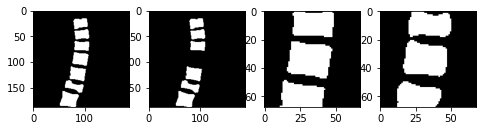


Loss: 0.06917418539524078


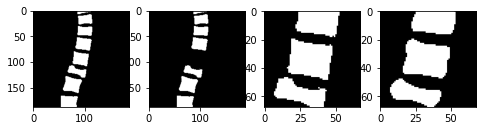


Loss: 0.06716032326221466


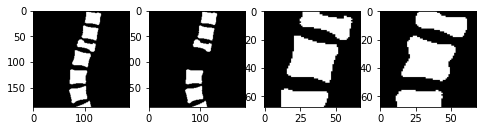


Loss: 0.06282716244459152


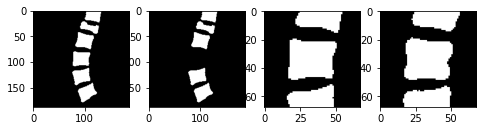


Loss: 0.06330510973930359


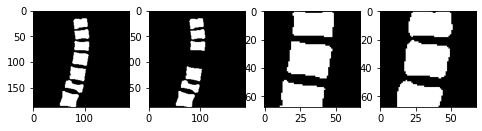


Loss: 0.0678621307015419


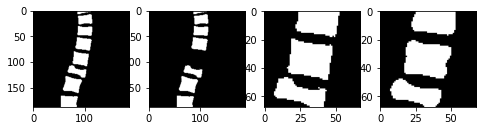


Loss: 0.07095039635896683


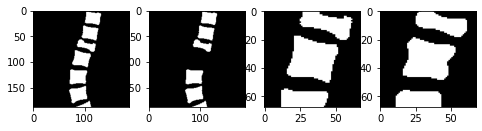


Loss: 0.05850281938910484


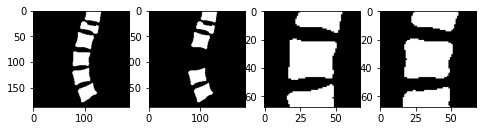


Loss: 0.0649762898683548


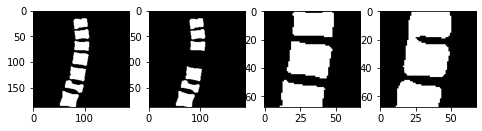


Loss: 0.06899485737085342


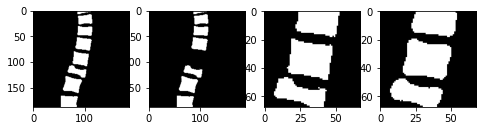


Loss: 0.06685568392276764


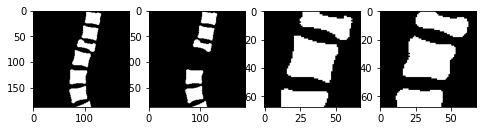


Loss: 0.06032416969537735


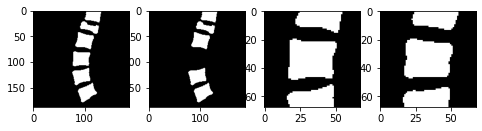


Loss: 0.06094292551279068


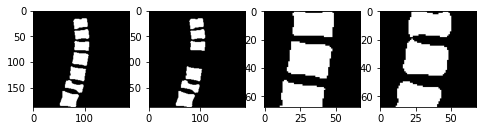


Loss: 0.0664694756269455


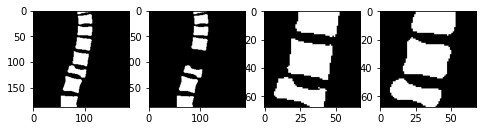


Loss: 0.0698467493057251


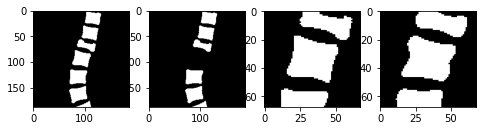


Loss: 0.05940363183617592


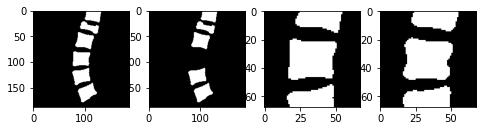


Loss: 0.06400979310274124


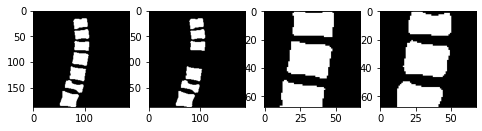


Loss: 0.06997369229793549


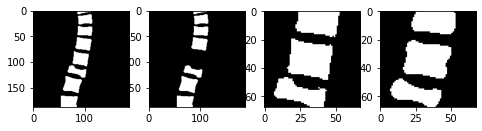


Loss: 0.06523269414901733


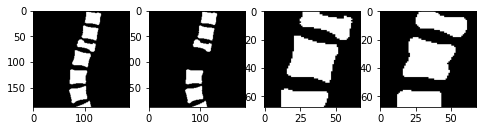


Loss: 0.05889086425304413


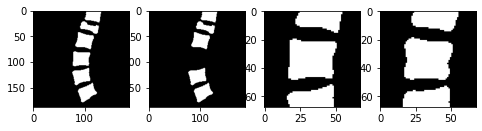


Loss: 0.06520985066890717


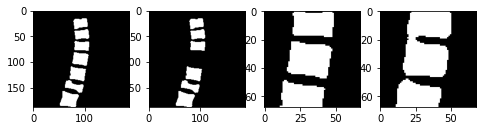


Loss: 0.06480497866868973


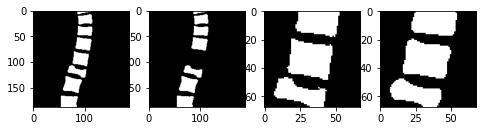


Loss: 0.06812913715839386


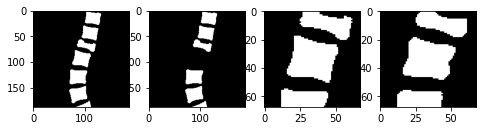


Loss: 0.06463374942541122


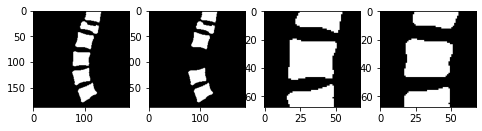


Loss: 0.05966106429696083


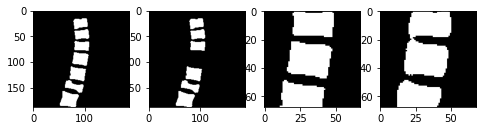


Loss: 0.06639950722455978


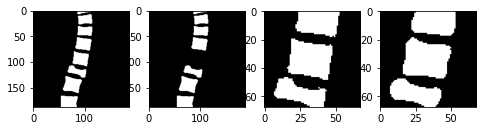


Loss: 0.06889397650957108


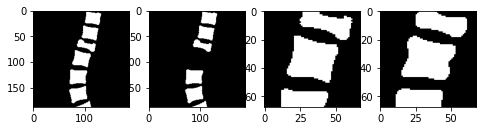


Loss: 0.0556052029132843


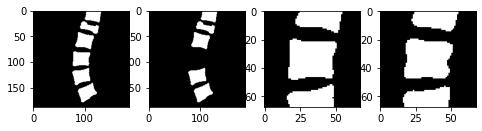


Loss: 0.06253989785909653


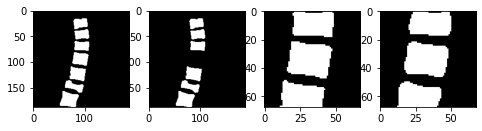


Loss: 0.06993602961301804


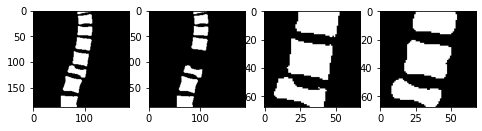


Loss: 0.06472667306661606


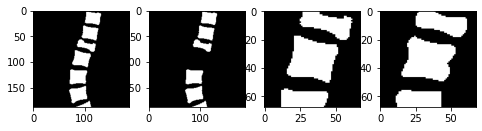


Loss: 0.06067553162574768


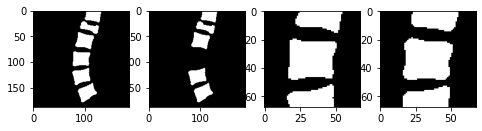


Loss: 0.06197104603052139


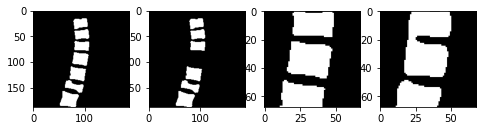


Loss: 0.06612545996904373


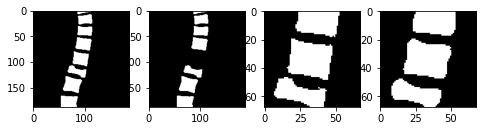


Loss: 0.0668865367770195


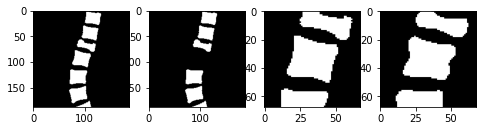


Loss: 0.05850596725940704


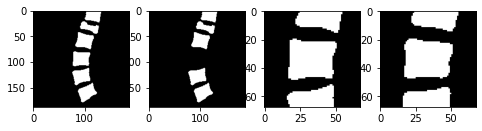


Loss: 0.059904709458351135


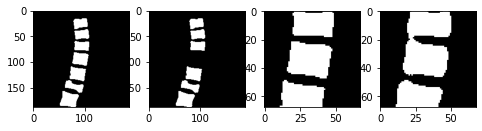


Loss: 0.06733369082212448


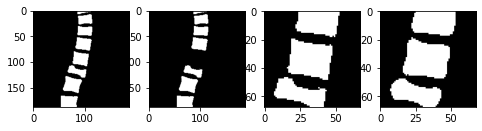


Loss: 0.06693204492330551


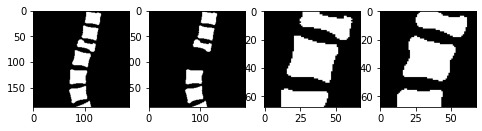


Loss: 0.056389957666397095


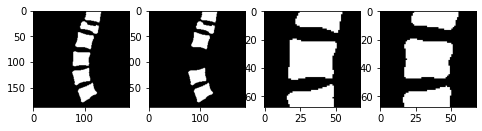


Loss: 0.06814273446798325


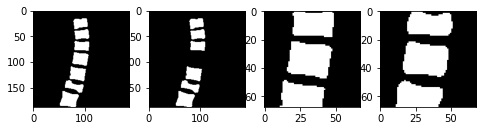


Loss: 0.06357143074274063


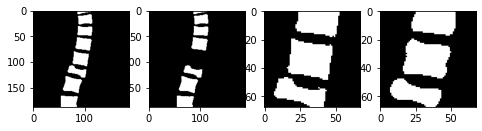


Loss: 0.06990412622690201


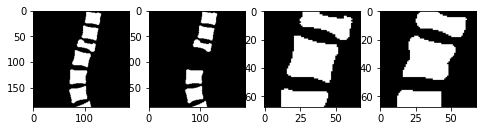


Loss: 0.05950213596224785


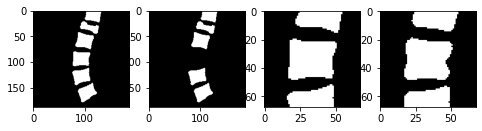


Loss: 0.0635777935385704


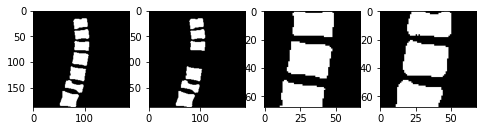


Loss: 0.06769692897796631


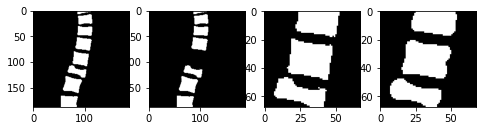


Loss: 0.0689609944820404


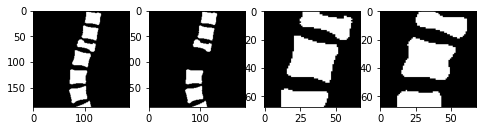


Loss: 0.0662250742316246


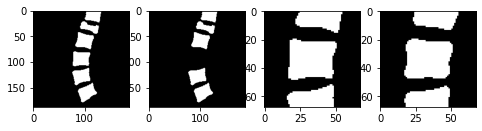


Loss: 0.06694681197404861


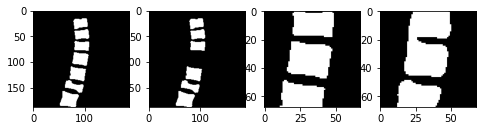


Loss: 0.06737293303012848


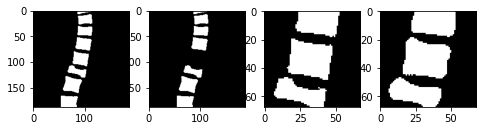


Loss: 0.0845227912068367


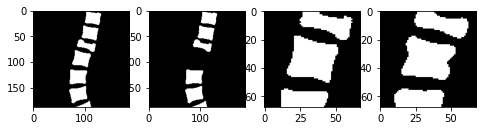


Loss: 0.05803738534450531


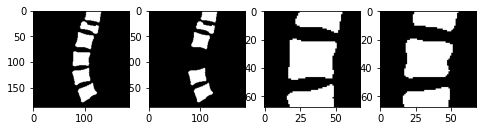


Loss: 0.07434620708227158


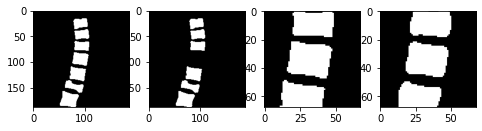


Loss: 0.07457469403743744


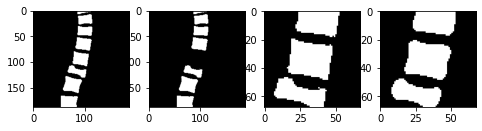


Loss: 0.0658004954457283


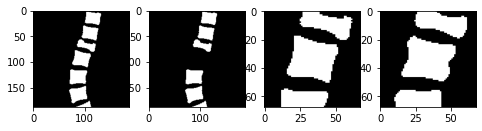


Loss: 0.07274223119020462


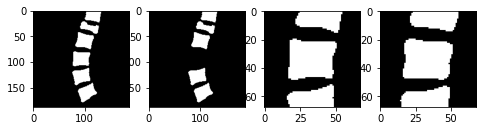


Loss: 0.06037931889295578


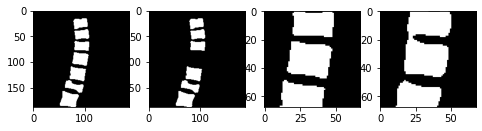


Loss: 0.0765284076333046


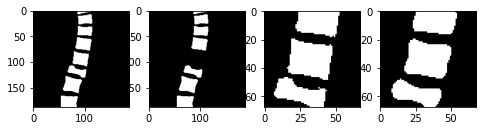


Loss: 0.07439829409122467


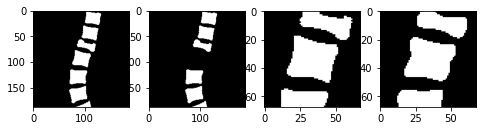


Loss: 0.05695423111319542


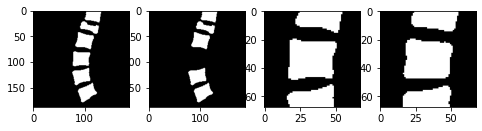


Loss: 0.07704637199640274


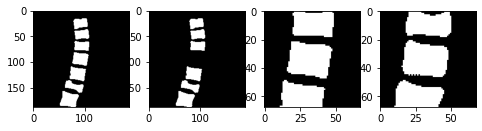


Loss: 0.06689981371164322


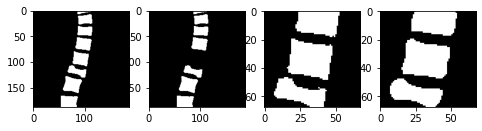


Loss: 0.06396987289190292


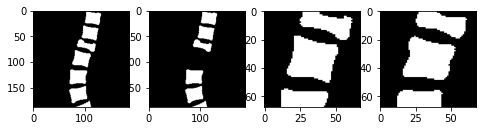


Loss: 0.06598304212093353


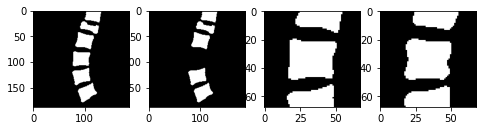


Loss: 0.05909331142902374


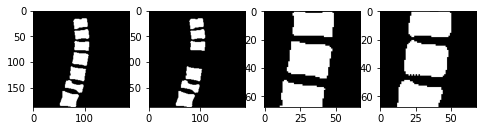


Loss: 0.06475455313920975


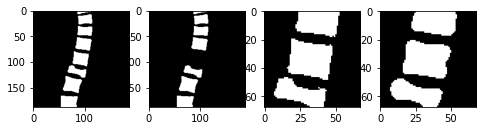


Loss: 0.07577936351299286


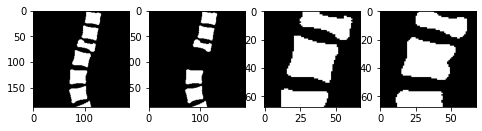


Loss: 0.055846020579338074


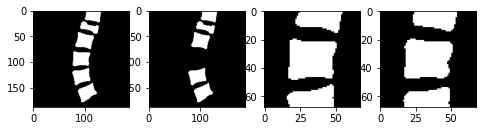


Loss: 0.06593471020460129


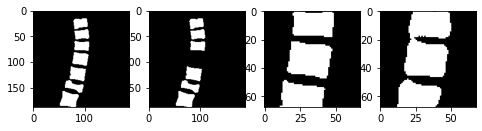


Loss: 0.07268130779266357


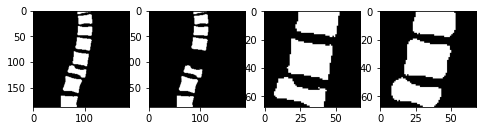


Loss: 0.06500725448131561


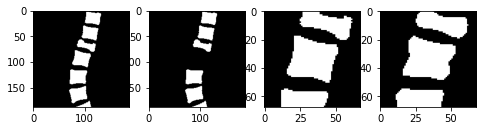


Loss: 0.06032988056540489


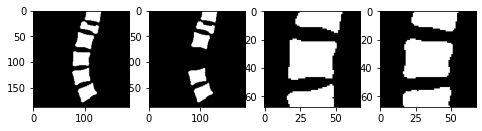


Loss: 0.062595896422863


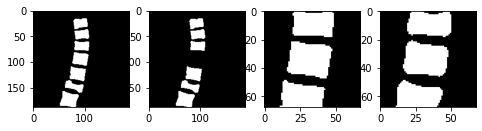


Loss: 0.06299387663602829


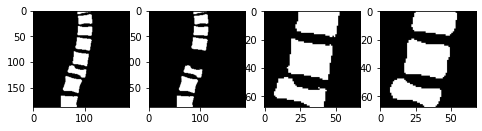


Loss: 0.0730869472026825


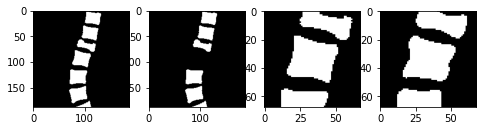


Loss: 0.05758565291762352


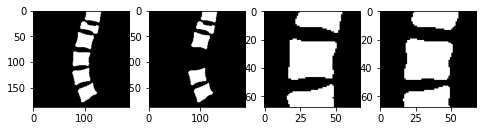


Loss: 0.06176256760954857


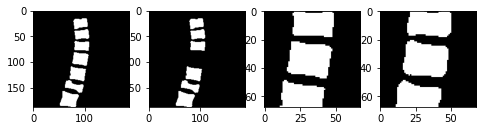


Loss: 0.06738293915987015


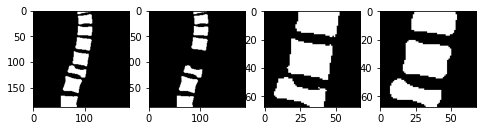


Loss: 0.062108639627695084


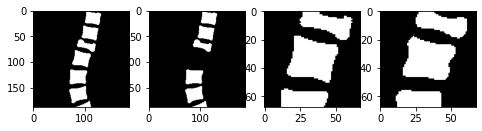


Loss: 0.05817464739084244


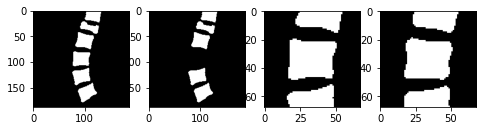


Loss: 0.06218460202217102


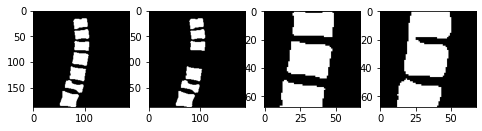


Loss: 0.06325527280569077


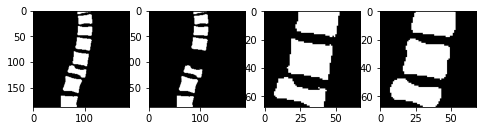


Loss: 0.06764742732048035


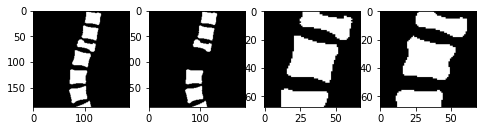


Loss: 0.059384845197200775


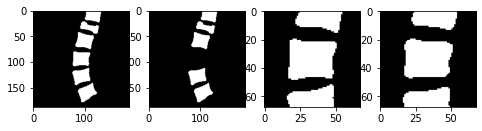


Loss: 0.05711071938276291


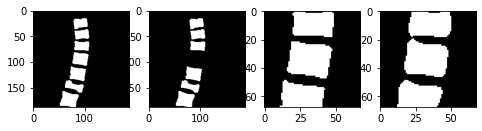


Loss: 0.0655001550912857


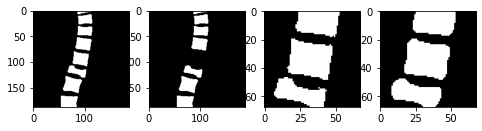


Loss: 0.06203409284353256


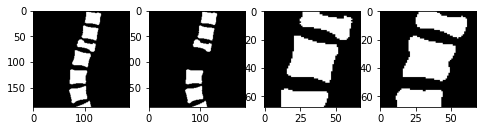


Loss: 0.054170768707990646


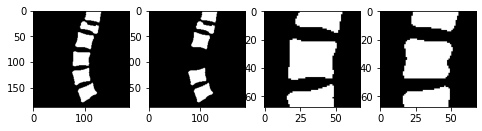


Loss: 0.05802009254693985


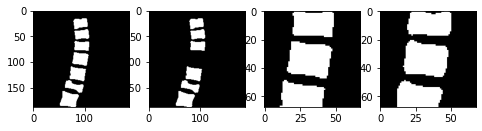


Loss: 0.06258970499038696


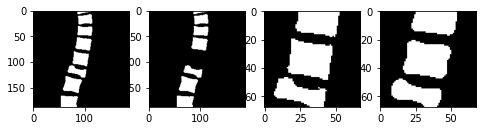


Loss: 0.060533557087183


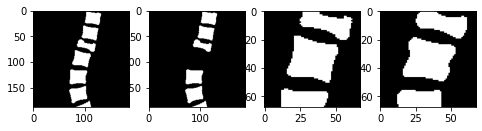


Loss: 0.05424864962697029


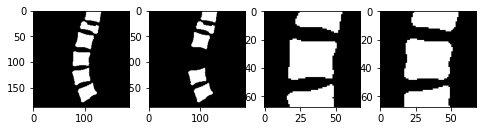


Loss: 0.057821206748485565


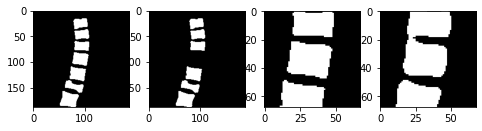


Loss: 0.0604129284620285


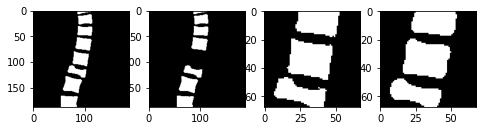


Loss: 0.06099553778767586


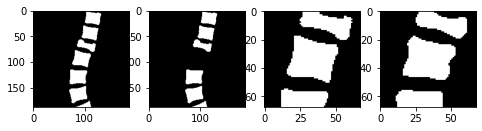


Loss: 0.0536007434129715


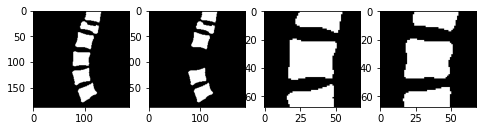


Loss: 0.05560261756181717


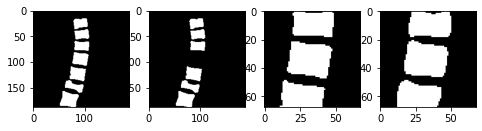


Loss: 0.062227968126535416


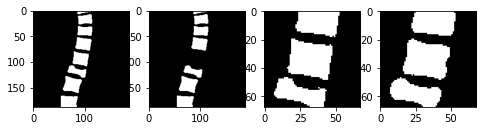


Loss: 0.05862926319241524


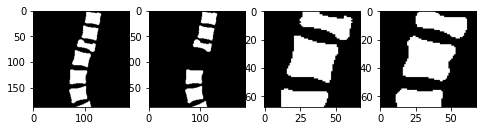


Loss: 0.05164119601249695


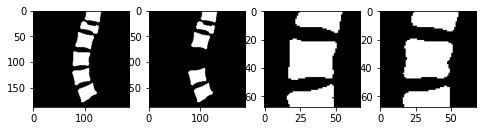


Loss: 0.05508233606815338


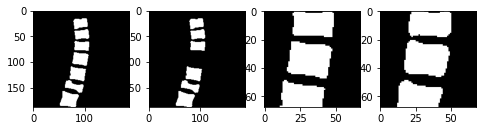


Loss: 0.061033934354782104


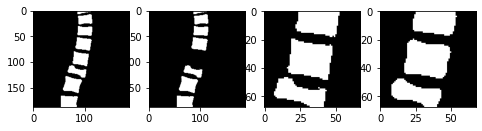


Loss: 0.058749426156282425


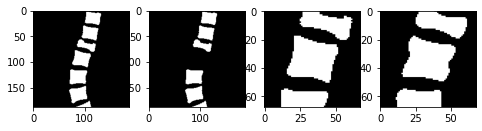


Loss: 0.05245337635278702


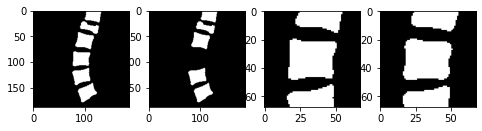


Loss: 0.05525429546833038


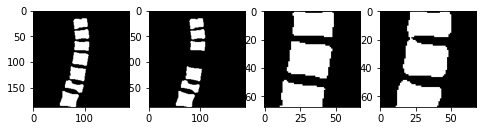


Loss: 0.05891800671815872


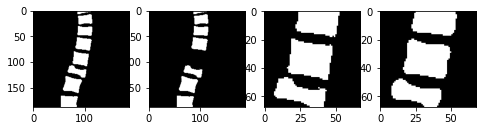


Loss: 0.058049414306879044


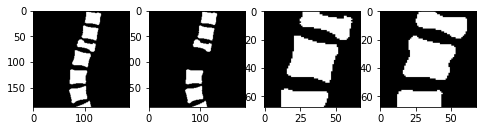


Loss: 0.050124067813158035


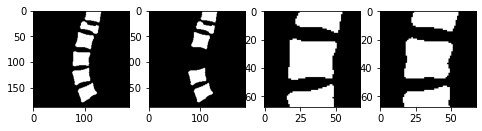


Loss: 0.055307790637016296


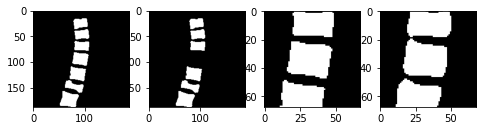


Loss: 0.05834498256444931


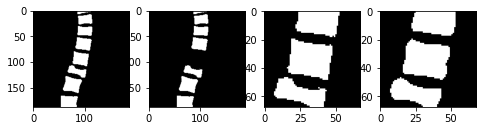


Loss: 0.05774117261171341


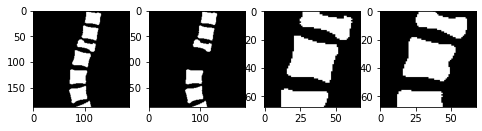


Loss: 0.05186637118458748


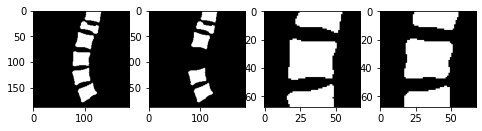


Loss: 0.054444435983896255


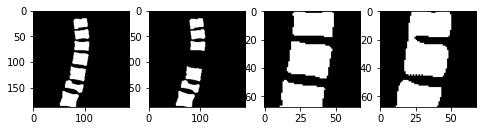


Loss: 0.05879336595535278


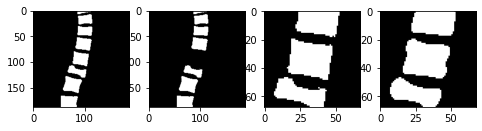


Loss: 0.06000550836324692


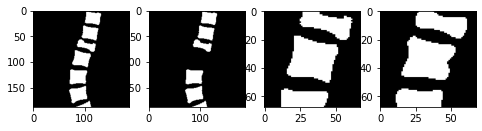


Loss: 0.04940361902117729


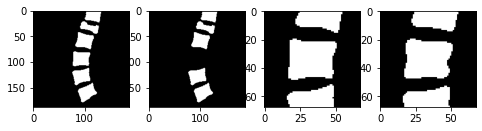


Loss: 0.05659257248044014


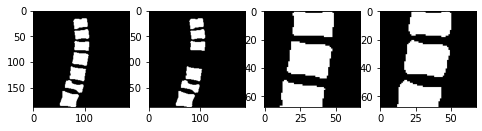


Loss: 0.06157240271568298


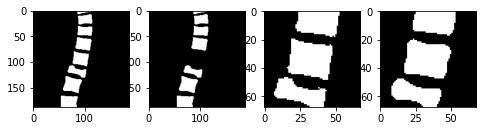


Loss: 0.05914666876196861


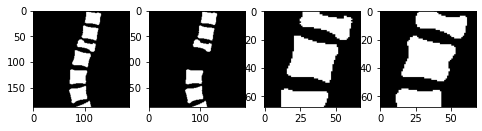


Loss: 0.05470499396324158


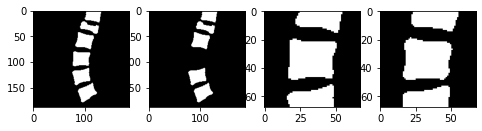


Loss: 0.05479928478598595


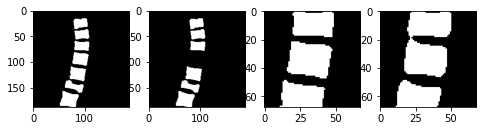


Loss: 0.06332378089427948


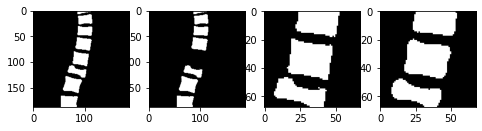


Loss: 0.05987365171313286


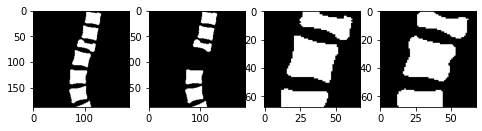


Loss: 0.051453594118356705


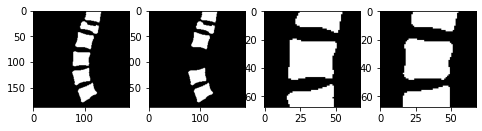


Loss: 0.06328350305557251


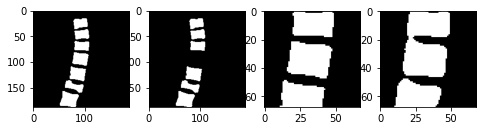


Loss: 0.057864926755428314


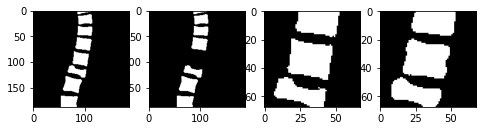


Loss: 0.06489118188619614


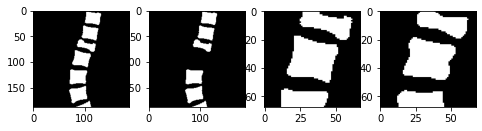


Loss: 0.05786896124482155


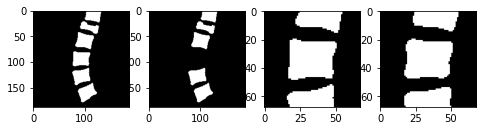


Loss: 0.057161007076501846


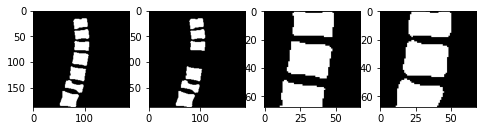


Loss: 0.0700371265411377


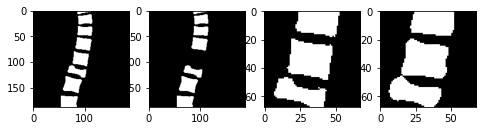


Loss: 0.06638694554567337


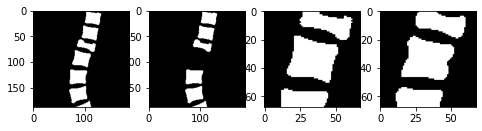


Loss: 0.054117560386657715


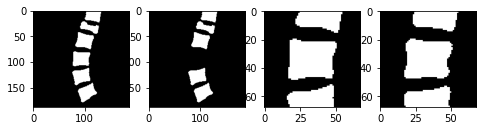


Loss: 0.0717417299747467


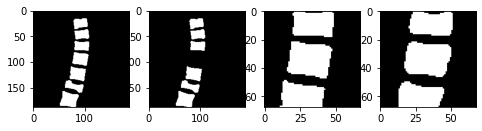


Loss: 0.06963416934013367


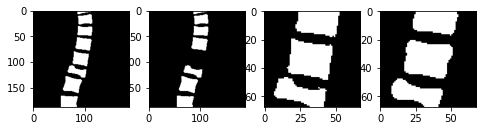


Loss: 0.06435341387987137


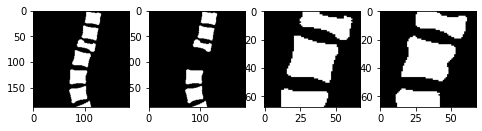


Loss: 0.060549408197402954


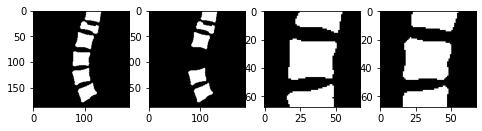


Loss: 0.06174568086862564


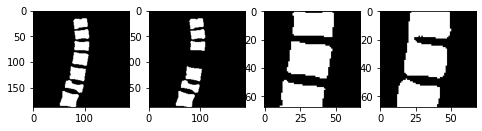


Loss: 0.06466203182935715


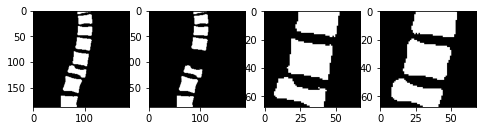


Loss: 0.0700659230351448


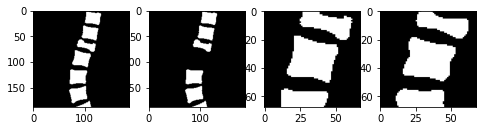


Loss: 0.0552179329097271


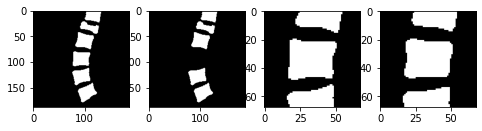


Loss: 0.05704474076628685


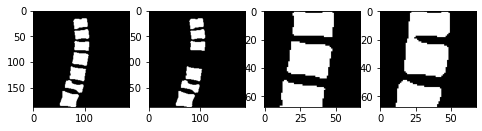


Loss: 0.06622079014778137


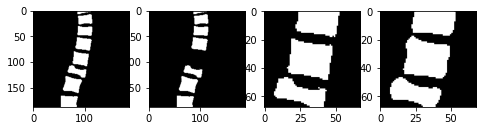


Loss: 0.06148519366979599


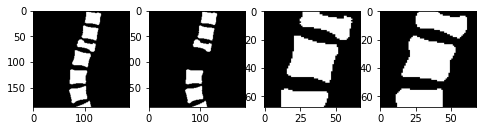


Loss: 0.05255897343158722


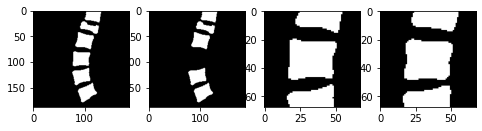


Loss: 0.057207345962524414


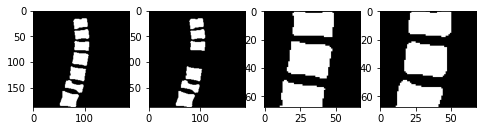


Loss: 0.061962660402059555


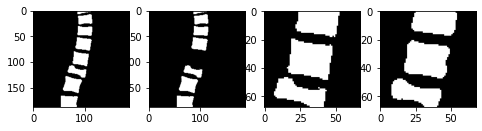


Loss: 0.058291904628276825


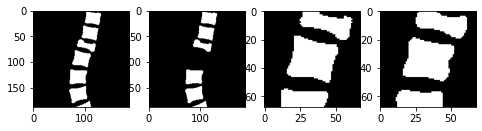


Loss: 0.05003781616687775


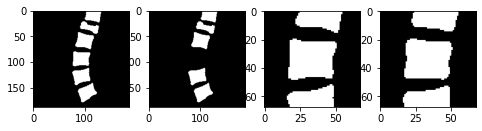


Loss: 0.057799082249403


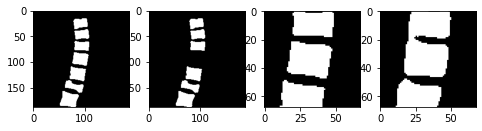


Loss: 0.06223681569099426


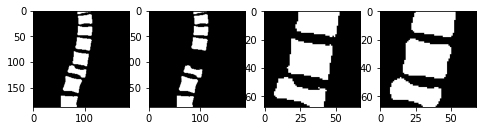


Loss: 0.059232041239738464


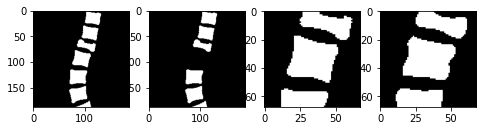


Loss: 0.053580231964588165


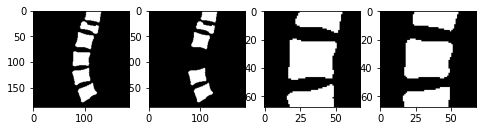

In [11]:
# define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(unet.parameters(), lr=0.0001)

for epoch in range(200):
    for m, z in train_loader:      # m is complete mask, z is incomplete mask
        optimizer.zero_grad()        
        m_pred = unet.forward(z.to(device))
        pred_shape = m_pred.shape
        print()

        # extract middle, for which a prediction is made, from the complete mask
        start = (patch_size[-1] - pred_shape[-1]) // 2
        end = start + pred_shape[-1]
        m_true = m[:, :, start:end, start:end, start:end].to(device)
        
        # compute loss & update
#         sigdiceloss = SigmoidDiceLoss()
#         loss = sigdiceloss.forward(torch.sigmoid(m_pred), m_true)
#         l1_loss = torch.nn.L1Loss()
#         loss = l1_loss(m_pred, m_true)

        loss = criterion(m_pred, m_true)
        loss.backward()
        optimizer.step()
        print('Loss: {}'.format(loss))   
        
        m_hard = m_pred.detach() > 0
        plt.figure(figsize=(10, 8))
        plt.subplot(151)
        plt.imshow(m[0, 0, 94, :, :].cpu().detach(), cmap='gray')
        plt.subplot(152)
        plt.imshow(z[0, 0, 94, :, :].cpu().detach(), cmap='gray')
        plt.subplot(153)
        plt.imshow(m_true[0, 0, 34, :, :].cpu().detach(), cmap='gray')
        plt.subplot(154)
        plt.imshow(m_hard[0, 0, 34, :, :].cpu().detach(), cmap='gray')
        plt.show()

In [12]:
len(train_loader)

4